# Using dGPS on GLE to Validate the Fusion Strategy

In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl

ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))

SHOW_FIGS = False

In [2]:
# _df = pl.scan_parquet(
#     "/BittleLab/7 DOE Project/radar-data/prepared_data/merged_trajectories/merged_trajectories.parquet"
# )

# _df.columns

## Read the GLE Data


In [3]:
# Length of the GLE

GLE_m = 4.93522
DIST_2_FRONT_m = 2.91
DIST_2_BACK_m = 1.99


veh_df = (
    pl.read_csv(
        ROOT / "data" / "vehicle_drives" / "2023-10-31.csv",
    )
    .drop("")
    .with_columns(
        pl.col("gps_time").str.strptime(
            dtype=pl.Datetime(
                time_unit="us",
            ),
        ),
    )
    .sort(
        "gps_time",
    )
    .with_row_count(name="seq")
)

## Create the Network


In [4]:
import geopandas as gpd
from src.geometry import RoadNetwork


mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
    step_size=0.01,
)

full_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=None,
    step_size=0.01,
)

LANE_WIDTH = 3.55
LANE_NUM = 2

## Snap the Vehicle Trajectories to Lanes


In [5]:
import utm
from src.pipelines.lane_classification import label_lanes_tree

x, y, _, _ = utm.from_latlon(
    latitude=veh_df["lat"].to_numpy(),
    longitude=veh_df["lon"].to_numpy(),
)

GLE_m = 4.93522
DIST_2_FRONT_m = 2.91
DIST_2_BACK_m = 1.99


veh_df = (
    veh_df.sort("gps_time")
    .with_columns(
        x=x,
        y=y,
        gps_time=pl.col("gps_time").dt.truncate("100ms"),
    )
    .with_columns(
        pl.col("x").diff().alias("dx"),
        pl.col("y").diff().alias("dy"),
    )
    .with_columns(
        (pl.col("dx").pow(2) + pl.col("dy").pow(2)).sqrt().alias("dist"),
        # find the heading
        pl.arctan2(pl.col("dy"), pl.col("dx")).alias("heading"),
    )
    .with_columns(
        pl.col("dist").cum_sum().alias("cum_dist"),
        # make the front x/y position
        (pl.col("x") + (DIST_2_FRONT_m * pl.col("heading").cos())).alias("front_x"),
        (pl.col("y") + (DIST_2_FRONT_m * pl.col("heading").sin())).alias("front_y"),
        (pl.col("x") - (DIST_2_BACK_m * pl.col("heading").cos())).alias("back_x"),
        (pl.col("y") - (DIST_2_BACK_m * pl.col("heading").sin())).alias("back_y"),
    )
    .with_columns(
        #
        (
            (pl.col("cum_dist").shift(-1) - pl.col("cum_dist").shift(1)).abs()
            / (
                (
                    pl.col("gps_time").shift(-1) - pl.col("gps_time").shift(1)
                ).dt.total_milliseconds()
                / 1e3
            )
        ).alias("speed"),
    )
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=LANE_WIDTH * LANE_NUM
        - (LANE_WIDTH / 2)
        + 0.5,  # centered on one of the lanes,
        utm_x_col="x",
        utm_y_col="y",
    )
    .filter(
        pl.col("name").is_not_null()
        & (pl.col("s") > 150)
        & (pl.col("s") < (pl.col("s").max() - 150)).over("name")
    )
    .rename(
        {
            "name": "lane",
            "angle": "heading_lane",
        }
    )
    .with_columns((pl.col("heading") - pl.col("heading_lane")).alias("angle_diff"))
    .with_columns(
        # find the portion of velocity that is in the direction of the lane
        pl.arctan2(pl.col("angle_diff").sin(), pl.col("angle_diff").cos()).alias(
            "angle_diff"
        )
    )
    .with_columns(
        (pl.col("speed") * pl.col("angle_diff").cos()).alias("s_velocity"),
        (pl.col("speed") * pl.col("angle_diff").sin()).alias("d_velocity"),
        ((DIST_2_FRONT_m * pl.col("angle_diff").cos()) + pl.col("s")).alias("front_s"),
        (pl.col("s") - (DIST_2_BACK_m * pl.col("angle_diff").cos())).alias("back_s"),
        # do the vehicle length
        (GLE_m * pl.col("angle_diff").cos()).alias("length_s"),
        pl.col("s").cast(pl.Float32).alias("s"),
    )
    .pipe(
        label_lanes_tree,
        full_network=full_net,
        kalman_network=mainline_net,
        lane_width=LANE_WIDTH,
        s_col="s",
        time_col="gps_time",
    )
)

veh_df.head()

shape: (5, 33)
┌──────┬─────────────┬───────────┬────────────┬───┬──────────┬─────────────┬──────────┬────────────┐
│ seq  ┆ gps_time    ┆ lat       ┆ lon        ┆ … ┆ length_s ┆ s_lane      ┆ d_cutoff ┆ d_other_ce │
│ ---  ┆ ---         ┆ ---       ┆ ---        ┆   ┆ ---      ┆ ---         ┆ ---      ┆ nter       │
│ u32  ┆ datetime[μs ┆ f64       ┆ f64        ┆   ┆ f64      ┆ f32         ┆ f64      ┆ ---        │
│      ┆ , UTC]      ┆           ┆            ┆   ┆          ┆             ┆          ┆ f64        │
╞══════╪═════════════╪═══════════╪════════════╪═══╪══════════╪═════════════╪══════════╪════════════╡
│ 1315 ┆ 2023-10-31  ┆ 33.235646 ┆ -87.610398 ┆ … ┆ 1.167358 ┆ 1235.327759 ┆ 1.850235 ┆ 3.70047    │
│      ┆ 16:45:34.20 ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│      ┆ 0 UTC       ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│ 1316 ┆ 2023-10-31  ┆ 33.235652 ┆ -87.610399 ┆ … ┆ 1.094715 ┆ 1235.477783 ┆ 1.850221 ┆ 3.700442   │
│      ┆ 16:45:34.30 ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│      ┆ 0 UTC       ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│ 1317 ┆ 2023-10-31  ┆ 33.235658 ┆ -87.610399 ┆ … ┆ 1.108874 ┆ 1235.627686 ┆ 1.850207 ┆ 3.700414   │
│      ┆ 16:45:34.40 ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│      ┆ 0 UTC       ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│ 1318 ┆ 2023-10-31  ┆ 33.235664 ┆ -87.610399 ┆ … ┆ 1.202335 ┆ 1235.797729 ┆ 1.850192 ┆ 3.700383   │
│      ┆ 16:45:34.50 ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│      ┆ 0 UTC       ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│ 1319 ┆ 2023-10-31  ┆ 33.235671 ┆ -87.610399 ┆ … ┆ 1.270158 ┆ 1235.977783 ┆ 1.85017  ┆ 3.70034    │
│      ┆ 16:45:34.60 ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
│      ┆ 0 UTC       ┆           ┆            ┆   ┆          ┆             ┆          ┆            │
└──────┴─────────────┴───────────┴────────────┴───┴──────────┴─────────────┴──────────┴────────────┘

## Read in the Radar Trajectories 

Both the prcessed and unprocessed.

### Raw Radar Data

In [6]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df
from src.pipelines.association import add_front_back_s
from src.pipelines.kalman_filter import prepare_frenet_measurement


radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "october_calibrated.yaml",
)


raw_radar_df = (
    pl.scan_parquet(
        Path(os.environ.get("RAW_DATA_DIR")).joinpath("*.parquet"),
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .with_context(veh_df.lazy())
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("gps_time").min() - timedelta(minutes=1),
            pl.col("gps_time").max() + timedelta(minutes=1),
        )
    )
    .with_columns(
        (pl.col("f32_positionX_m") ** 2 + pl.col("f32_positionY_m") ** 2)
        .sqrt()
        .alias("dist"),
    )
    .filter(
        pl.when(pl.col("ip").is_in(["10.160.7.141", "10.160.7.137"]))
        .then(pl.col("dist") < 300)
        .otherwise(pl.lit(True))
    )
    .collect()
    .lazy()
    .pipe(prep_df, f=radar_obj)
    .collect()
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=LANE_WIDTH * LANE_NUM
        - (LANE_WIDTH / 2)
        + 0.5,  # centered on one of the lanes,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .with_columns(
        (pl.col("dist").diff().backward_fill(1).over("object_id") < 0).alias(
            "approaching"
        ),
        pl.col("s").cast(pl.Float32).alias("s"),
    )
    .rename(
        {
            "name": "lane",
            "angle": "heading_lane",
        }
    )
    .pipe(prepare_frenet_measurement)
    .pipe(add_front_back_s, use_median_length=False, use_nearest_length=False)
    .with_columns(
        ((pl.col("back_s") + pl.col("front_s")) / 2).cast(pl.Float32).alias("s"),
    )
    # .sort("epoch_time")
    .collect()
    .pipe(
        label_lanes_tree,
        full_network=full_net,
        kalman_network=mainline_net,
        lane_width=LANE_WIDTH,
        s_col="s",
        time_col="epoch_time",
    )
    .drop("s_lane")
    .rename({"s": "centroid_s"})
)


transformations = [
    ("front_s", "d", "front_x", "front_y"),
    ("back_s", "d", "back_x", "back_y"),
    ("centroid_s", "d", "centroid_x", "centroid_y"),
]

for s_col, d_col, x_col, y_col in transformations:
    raw_radar_df = (
        raw_radar_df.pipe(
            mainline_net.frenet2xy,
            lane_col="lane",
            s_col=s_col,
            d_col=d_col,
        )
        .drop(["s", "angle"])
        .rename({"x_lane": x_col, "y_lane": y_col})
    )

function: create_object_id took: 0.00036907196044921875 seconds
function: filter_short_trajectories took: 0.0004999637603759766 seconds
function: clip_trajectory_end took: 0.00023436546325683594 seconds
function: resample took: 0.00027489662170410156 seconds
function: fix_duplicate_positions took: 0.0001270771026611328 seconds
function: set_timezone took: 5.1021575927734375e-05 seconds
function: add_cst_timezone took: 3.910064697265625e-05 seconds
function: add_heading took: 4.029273986816406e-05 seconds
function: rotate_radars took: 0.0006289482116699219 seconds
function: update_origin took: 0.0004076957702636719 seconds
function: prepare_frenet_measurement took: 0.000598907470703125 seconds
function: add_front_back_s took: 8.463859558105469e-05 seconds


### Read in the Processed Radar Data

In [7]:
processed_radar_df = pl.read_parquet(
    ROOT / "data" / "merged_october_2_meas.parquet",
)

processed_radar_df.head()

shape: (5, 44)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_inde ┆ ci_s      ┆ ci_s_velo ┆ ci_s_acce ┆ … ┆ ci_back_x ┆ ci_back_y ┆ ci_centro ┆ ci_centr │
│ x         ┆ ---       ┆ city      ┆ l         ┆   ┆ ---       ┆ ---       ┆ id_x      ┆ oid_y    │
│ ---       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---      │
│ u32       ┆           ┆ f32       ┆ f32       ┆   ┆           ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 21.308594 ┆ 19.147093 ┆ 0.0       ┆ … ┆ 443542.68 ┆ 3.6777e6  ┆ 443542.12 ┆ 3.6777e6 │
│           ┆           ┆           ┆           ┆   ┆ 4935      ┆           ┆ 4608      ┆          │
│ 0         ┆ 21.622359 ┆ 25.097843 ┆ 0.0       ┆ … ┆ 441955.50 ┆ 3.6773e6  ┆ 441956.38 ┆ 3.6773e6 │
│           ┆           ┆           ┆           ┆   ┆ 8862      ┆           ┆ 4116      ┆          │
│ 0         ┆ 23.454606 ┆ 18.659729 ┆ 0.0       ┆ … ┆ 441958.58 ┆ 3.6773e6  ┆ 441959.06 ┆ 3.6773e6 │
│           ┆           ┆           ┆           ┆   ┆ 7559      ┆           ┆ 5559      ┆          │
│ 1         ┆ 23.584194 ┆ 19.184017 ┆ 0.007041  ┆ … ┆ 443540.56 ┆ 3.6777e6  ┆ 443540.02 ┆ 3.6777e6 │
│           ┆           ┆           ┆           ┆   ┆ 454       ┆           ┆ 3535      ┆          │
│ 1         ┆ 24.115885 ┆ 25.085623 ┆ -0.005659 ┆ … ┆ 441957.93 ┆ 3.6773e6  ┆ 441958.77 ┆ 3.6773e6 │
│           ┆           ┆           ┆           ┆   ┆ 0401      ┆           ┆ 5887      ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

#### Remove any Bad Matches in the Association

In [8]:
processed_radar_df["vehicle_id"].n_unique()

3854

In [9]:
# processed_radar_df = processed_radar_df.filter(
#     (pl.col("ci_s_velocity") > -5).all().over("vehicle_id")
# )

In [10]:
# chi.ppf(0.9999, 4)

In [11]:
# processed_radar_df = processed_radar_df.filter(
#     pl.col("vehicle_id").is_in(
#         processed_radar_df.group_by("vehicle_id")
#         .agg(
#             pl.col("association_distance")
#             .filter(pl.col("association_distance").is_not_null())
#             .mean()
#         )
#         .fill_null(0)
#         .filter(pl.col("association_distance") < 20)["vehicle_id"]
#     )
# )

In [12]:
# from scipy.stats import chi

# processed_radar_df = processed_radar_df.filter(
#     pl.col("association_distance")
#     .filter(pl.col("association_distance").is_not_null())
#     .quantile(0.75)
#     .over("vehicle_id")
#     < 10
# )

In [13]:
processed_radar_df["vehicle_id"].n_unique()

3854

In [14]:
crop_s = processed_radar_df.group_by(["lane", "lane_index"]).agg(
    pl.col("ci_front_s").quantile(0.05).alias("quanitile_5"),
    pl.col("ci_front_s").quantile(0.95).alias("quanitile_95"),
)

### Read in the Imtermediate IMM Filtered Data

In [15]:
imm_filter_df = (
    pl.scan_parquet(
        ROOT / "data" / "october_kalman_2d_meas.parquet",
    )
    .filter(~pl.col("prediction"))
    .collect()
)

## Calculate the Optimal Time Offset b/ Radar and GPS

In [16]:
veh_df = (
    veh_df.with_columns(
        pl.col("lane").fill_null(""),
    )
    .with_columns(
        (
            (pl.col("gps_time").diff().dt.total_seconds() > 10)
            | (pl.col("lane").shift(1) != pl.col("lane"))
        ).alias("sequence"),
    )
    .with_columns(
        (pl.col("sequence").cum_sum() * (pl.col("lane") != "")).alias("sequence_id"),
    )
    .filter(pl.col("sequence_id") != 0)
)


veh_df = veh_df.with_columns(
    # (pl.col("lane").str.slice(-1, 1).cast(pl.UInt32) - 1).alias("lane_index"),
    # pl.concat_str(pl.col("lane").str.slice(0, 3), pl.lit("1")).alias("lane"),
    pl.col("gps_time").cast(raw_radar_df["epoch_time"].dtype).alias("epoch_time"),
)

veh_df = (
    veh_df.join(
        crop_s.with_columns(pl.col("lane_index").cast(pl.UInt16)),
        on=["lane", "lane_index"],
        how="left",
    )
    .filter(pl.col("front_s").is_between(pl.col("quanitile_5"), pl.col("quanitile_95")))
    .drop(["quanitile_5", "quanitile_95"])
    .sort("gps_time")
    .with_columns(
        pl.col("front_s").diff().sum().over(["sequence_id"]).alias("sequence_distance"),
    )
)


# veh_df = veh_df.filter(pl.count().over("sequence_id") > 50)

### Create a Function to Calculate the Offset

In [17]:
def offset_error(veh_df, radar_df, offset):
    # this function treis to eagerly join the two dataframes
    return (
        veh_df
        # .lazy()
        .with_columns(
            pl.col("epoch_time") + timedelta(seconds=offset),
        )
        .filter(pl.col("epoch_time").is_in(radar_df["epoch_time"].unique()))
        # .sort("s")
        .join(
            (
                radar_df
                # .sort("s").with_columns(pl.col("s").alias("s_radar"))
            ),
            # on="s",
            on=[
                "epoch_time",
                "lane",
            ],
            suffix="_radar",
            # strategy='nearest'
            # how="inner",
        )
        # .filter((pl.col('s_radar') - pl.col('s')).abs() < 10)
        .with_columns(
            # calculate the rms error
            ((pl.col("s") - pl.col("s_radar")) ** 2).alias("s_squared_error"),
            ((pl.col("speed") - pl.col("speed_radar")) ** 2).alias(
                "s_velocity_squared_error"
            ),
        )
        .group_by(["vehicle_id", "sequence_id"])
        .agg(
            (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
            (pl.col("s_velocity_squared_error").sum() / pl.count())
            .sqrt()
            .alias("s_velocity_rmse"),
        )
        .group_by("sequence_id")
        .agg(
            pl.col("vehicle_id")
            .gather(pl.col("s_rmse").arg_min())
            .alias("min_rmse_vehicle_id"),
            pl.col("vehicle_id")
            .gather(pl.col("s_velocity_rmse").arg_min())
            .alias("min_s_velocity_rmse_vehicle_id"),
            pl.col("s_rmse").min().alias("min_rmse"),
            pl.col("s_velocity_rmse").min().alias("min_s_velocity_rmse"),
        )
        .explode(["min_rmse_vehicle_id", "min_s_velocity_rmse_vehicle_id"])
        # .collect()
    )

### Find the Optimal Offset

In [18]:
error_summary = []

e_df = (
    veh_df.with_columns(
        pl.col("gps_time").cast(raw_radar_df["epoch_time"].dtype).alias("epoch_time"),
        pl.col("front_s").cast(float).alias("s"),
        pl.col("lane_index").alias("lane_index"),
    )
    .sort("s")
    .set_sorted("s")
)

# ee_df = (
#     raw_radar_df.drop("lane_index")
#     .with_columns(
#     # processed_radar_df.with_columns(
#         pl.col("front_s").cast(float).alias("s"),
#         pl.col("s_velocity").alias("speed_radar"),
#         # pl.col("ci_s").cast(float).alias("s"),
#         # pl.col("ci_s_velocity").alias("speed_radar"),
#         pl.col("object_id").alias("vehicle_id"),
#         (pl.col("lane").str.slice(-1, 1).cast(pl.UInt32) - 1).alias("lane_index"),
#         pl.concat_str(pl.col("lane").str.slice(0, 3), pl.lit("1")).alias("lane"),
#         # pl.col("lane_index").cast(pl.UInt32).alias("lane_index"),
#     )
#     .sort("s")
#     .set_sorted("s")
# )

ee_df = (
    processed_radar_df.with_columns(
        pl.col("front_s_smooth").cast(float).alias("s"),
        pl.col("s_velocity_smooth").alias("speed_radar"),
        # pl.col("lane_index").cast(pl.UInt32).alias("lane_index"),
    )
    .sort("s")
    .set_sorted("s")
)

for second_offset in range(-200, -100, 1):
    error_df = offset_error(
        e_df,
        ee_df,
        second_offset / 10,
    )

    error_summary.append(
        error_df.with_columns(
            pl.lit(second_offset / 10).alias("second_offset"),
        )
    )

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

error_summary_df = pl.concat(error_summary)

error_summary_df_seconds = (
    error_summary_df.group_by("second_offset")
    .agg(
        pl.col("min_rmse").min().alias("min_rmse"),
        pl.col("min_s_velocity_rmse").min().alias("min_s_velocity_rmse"),
    )
    .sort("second_offset")
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_rmse"],
        name="RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_s_velocity_rmse"],
        name="Speed RMSE",
    ),
    secondary_y=True,
)

fig.update_layout(
    height=800,
    width=1200,
    xaxis_title="Second Offset",
    yaxis_title="RMSE",
    yaxis2_title="Speed RMSE",
)

### Implement the Offset and Try to Cluster the Matching Vehicles

In [20]:
optimal_offset = error_summary_df_seconds.sort("min_rmse")["second_offset"][0]
optimal_offset = -15.5
print(f"Optimal offset: {optimal_offset}")

Optimal offset: -15.5


## Find the Vehicles that Best Match the GPS


In [21]:
offset_error(
    veh_df.with_columns(
        pl.col("gps_time").cast(raw_radar_df["epoch_time"].dtype).alias("epoch_time"),
        pl.col("front_s").cast(float).alias("s"),
    ),
    processed_radar_df.with_columns(
        pl.col("front_s_smooth").cast(float).alias("s"),
        pl.col("s_velocity_smooth").alias("speed_radar"),
        # pl.col("lane_index").cast(pl.UInt32).alias("lane_index"),
        # pl.col('object_id').alias('vehicle_id'),
    ),
    optimal_offset,
)

shape: (16, 5)
┌─────────────┬─────────────────────┬────────────────────────────┬───────────┬─────────────────────┐
│ sequence_id ┆ min_rmse_vehicle_id ┆ min_s_velocity_rmse_vehicl ┆ min_rmse  ┆ min_s_velocity_rmse │
│ ---         ┆ ---                 ┆ e_id                       ┆ ---       ┆ ---                 │
│ u32         ┆ u64                 ┆ ---                        ┆ f64       ┆ f64                 │
│             ┆                     ┆ u64                        ┆           ┆                     │
╞═════════════╪═════════════════════╪════════════════════════════╪═══════════╪═════════════════════╡
│ 6           ┆ 1438                ┆ 35                         ┆ 30.630991 ┆ 1.678079            │
│ 9           ┆ 825                 ┆ 456                        ┆ 83.068292 ┆ 8.60856             │
│ 15          ┆ 3780                ┆ 3780                       ┆ 0.653536  ┆ 0.275763            │
│ 2           ┆ 1180                ┆ 1180                       ┆ 1.349374  ┆ 0.436493            │
│ …           ┆ …                   ┆ …                          ┆ …         ┆ …                   │
│ 11          ┆ 2152                ┆ 1378                       ┆ 13.236703 ┆ 1.048921            │
│ 10          ┆ 1015                ┆ 2284                       ┆ 51.629907 ┆ 0.342427            │
│ 1           ┆ 146                 ┆ 146                        ┆ 26.421227 ┆ 2.11151             │
│ 16          ┆ 820                 ┆ 3189                       ┆ 2.294715  ┆ 0.2781              │
└─────────────┴─────────────────────┴────────────────────────────┴───────────┴─────────────────────┘

In [22]:
scatter_df = (
    veh_df.with_columns(
        (pl.col("gps_time") + timedelta(seconds=optimal_offset))
        .cast(processed_radar_df["epoch_time"].dtype)
        .alias("epoch_time"),
        pl.col("front_s").cast(float).alias("front_s"),
        pl.col("back_s").cast(float).alias("back_s"),
        pl.col("s").cast(float).alias("s"),
    )
    .filter(pl.col("epoch_time").is_in(processed_radar_df["epoch_time"].unique()))
    .join(
        processed_radar_df.select(
            [
                pl.col("front_s_smooth").cast(float).alias("front_s_radar"),
                pl.col("back_s_smooth").cast(float).alias("back_s_radar"),
                pl.col("s_smooth").cast(float).alias("s_radar"),
                pl.col("s_velocity_smooth").alias("speed_radar"),
                # pl.col("lane_index").cast(pl.UInt32).alias("lane_index"),
                "lane_index",
                "epoch_time",
                "vehicle_id",
                "lane",
            ]
        ),
        on=["epoch_time", "lane", "lane_index"],
        # how="outer",
    )
    .filter(pl.col("s_radar").is_not_nan())
    .with_columns(
        # calculate the rms error
        pl.min_horizontal(
            ((pl.col(col) - pl.col(f"{col}_radar")) ** 2)
            for col in ["front_s", "back_s", "s"]
        ).alias("s_squared_error"),
        ((pl.col("speed") - pl.col("speed_radar")) ** 2).alias(
            "s_velocity_squared_error"
        ),
    )
    .group_by(["vehicle_id", "sequence_id"])
    .agg(
        (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
        (pl.col("s_velocity_squared_error").sum() / pl.count())
        .sqrt()
        .alias("s_velocity_rmse"),
    )
)

In [23]:
# try to make two clusters
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2).fit(scatter_df[["s_rmse", "s_velocity_rmse"]].to_numpy())

scatter_df = scatter_df.with_columns(
    cluster=pl.Series(dbscan.labels_).cast(str),
)

In [24]:
import plotly.express as px


fig = px.scatter(
    scatter_df.to_pandas(),
    x="s_rmse",
    y="s_velocity_rmse",
    color="cluster",
    hover_data=["vehicle_id", "sequence_id"],
)

fig.show()

In [25]:
good_cluster = (
    scatter_df.group_by("cluster")
    .agg(
        pl.col("s_rmse").mean().alias("s_rmse"),
    )
    .sort("s_rmse")["cluster"][0]
)

print(f"Good cluster: {good_cluster}")

Good cluster: 0


In [26]:
good_matches = scatter_df.filter(pl.col("cluster") == good_cluster)

In [27]:
object_ids = (
    processed_radar_df.filter(
        pl.col("vehicle_id").is_in(good_matches["vehicle_id"].unique())
    )[["vehicle_id", "object_id"]]
    .unique()
    .explode("object_id")
)

## Calculate the Positional Error

We filter out short matches, as this happened when the vehicle crossed the lanes during turning movements

In [28]:
veh_df = veh_df.filter(pl.count().over("sequence_id") > 150)

In [29]:
raw_radar_df = raw_radar_df.filter(
    pl.col("object_id").is_in(object_ids["object_id"])
).join(
    object_ids,
    on="object_id",
)


imm_filter_df = imm_filter_df.filter(
    pl.col("object_id").is_in(object_ids["object_id"])
).join(
    object_ids,
    on="object_id",
)

# raw_error_df.head()

### Build a Paired DataFrame

In [30]:
paired_df = (
    veh_df.with_columns(
        (
            pl.col("gps_time").cast(raw_radar_df["epoch_time"].dtype)
            + timedelta(seconds=optimal_offset)
        ).alias("epoch_time"),
        pl.col("lane_index").cast(int),
        pl.lit(GLE_m).alias("length_s"),
        pl.col("x").alias("centroid_x"),
        pl.col("y").alias("centroid_y"),
    )
    .join(
        processed_radar_df.select(
            [
                "epoch_time",
                # RTS
                "s_smooth",
                "front_s_smooth",
                "back_s_smooth",
                "s_velocity_smooth",
                "d_smooth",
                "d_velocity_smooth",
                "front_x_smooth",
                "front_y_smooth",
                "back_x_smooth",
                "back_y_smooth",
                "centroid_x_smooth",
                "centroid_y_smooth",
                # (pl.col("front_s_smooth") - pl.col("back_s_smooth")).alias(
                #     "length_s_smooth"
                # ),
                pl.col("length_s").alias("length_s_smooth"),
                (
                    (pl.col("s_velocity_smooth") ** 2)
                    + (pl.col("d_velocity_smooth") ** 2)
                )
                .sqrt()
                .alias("speed_smooth"),
                # covariance intersection
                "ci_front_s",
                "ci_back_s",
                "ci_s",
                "ci_d",
                "ci_s_velocity",
                "ci_d_velocity",
                "ci_front_x",
                "ci_front_y",
                "ci_back_x",
                "ci_back_y",
                "ci_centroid_x",
                "ci_centroid_y",
                (
                    (pl.col("ci_s_velocity") ** 2 + pl.col("ci_d_velocity") ** 2).sqrt()
                ).alias("ci_speed"),
                # other
                "vehicle_id",
                "lane",
                pl.col("lane_index").cast(int),
                pl.col("length_s").alias("ci_length_s"),
                "prediction",
            ]
        ).filter(pl.col("vehicle_id").is_in(good_matches["vehicle_id"].unique())),
        on=["epoch_time", "lane", "lane_index"],
        suffix="_rts",
        how="left",
    )
    .join(
        raw_radar_df.select(
            [
                "epoch_time",
                "front_s",
                "back_s",
                pl.col("centroid_s").alias("s"),
                "s_velocity",
                "d",
                "d_velocity",
                pl.col("f32_velocityInDir_mps").alias("speed_raw"),
                pl.col("utm_x").alias("centroid_x_raw"),
                pl.col("utm_y").alias("centroid_y_raw"),
                "vehicle_id",
                "object_id",
                "ip",
                "front_x",
                "front_y",
                "back_x",
                "back_y",
                pl.col("length_s").alias("length_s_raw"),
                "dist",
                "approaching",
            ]
        ),
        on=["vehicle_id", "epoch_time"],
        suffix="_raw",
        how="left",
    )
    .join(
        imm_filter_df.select(
            [
                "epoch_time",
                pl.col("centroid_s").alias("s"),
                "front_s",
                "back_s",
                "s_velocity",
                "d",
                "d_velocity",
                "object_id",
                "vehicle_id",
                "front_x",
                "front_y",
                "back_x",
                "back_y",
                pl.col("centroid_x").alias("centroid_x_imm"),
                pl.col("centroid_y").alias("centroid_y_imm"),
                ((pl.col("s_velocity") ** 2) + (pl.col("d_velocity") ** 2))
                .sqrt()
                .alias("speed_imm"),
                (pl.col("front_s") - pl.col("back_s")).alias("length_s_imm"),
            ]
        ),
        on=["epoch_time", "vehicle_id"],
        suffix="_imm",
        how="left",
    )
)

In [31]:
error_df = paired_df.clone()

In [32]:
error_df = error_df.sort("epoch_time").with_columns(
    pl.col("front_s")
    .diff()
    .sum()
    .over(["sequence_id", "vehicle_id"])
    .alias("merged_trajectory_length"),
    pl.col("front_s")
    .diff()
    .sum()
    .over(["sequence_id", "vehicle_id", "object_id"])
    .alias("raw_trajectory_length"),
    pl.col("front_s")
    .filter(pl.col("object_id_imm").is_not_null())
    .diff()
    .sum()
    .over(["sequence_id", "vehicle_id", "object_id_imm"])
    .alias("imm_trajectory_length"),
)

In [33]:
# seq_df["vehicle_id"].replace(colors)

In [34]:
import plotly.graph_objects as go


fig = go.Figure()

error_df = error_df.sort("epoch_time")

# plot all the EB trajectories
for g, seq_df in error_df.group_by("sequence_id", maintain_order=True):
    seq_df = seq_df.sort("epoch_time").gather_every(10)

    veh_data = (
        veh_df.filter(pl.col("sequence_id") == g)
        .with_columns(
            pl.col("epoch_time") + timedelta(seconds=optimal_offset),
        )
        .gather_every(10)
    )

    # for _df in [seq_df, veh_data]:
    #     _df.with_columns(
    #         pl.when(pl.col("lane").str.slice(0, 3) == "EBL")
    #         .then(pl.col('^.*front_s.*$'))
    #     )

    fig.add_trace(
        go.Scatter(
            x=veh_data["epoch_time"],
            y=veh_data["front_s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
            showlegend=False,
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["front_s_raw"],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="green",
            showlegend=False,
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["front_s_imm"],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="purple",
            showlegend=False,
        ),
    )

    colors = dict(
        zip(seq_df["vehicle_id"].unique().to_list(), px.colors.qualitative.Plotly)
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["ci_front_s"],
            mode="markers ",
            name=f"Sequence {g}",
            # make the color by the vehicle id
            marker_color=seq_df["vehicle_id"].replace(colors),
            # line_color=seq_df["vehicle_id"].map_dict(colors),
            showlegend=False,
        ),
    )
    # # plot the trajectories


# if SHOW_FIGS:
fig.show()

In [35]:
error_df.pipe(radar_obj.add_cst_timezone).filter(pl.col("sequence_id") == 16)[
    ["lane", "lane_index", "vehicle_id"]
].unique()

function: add_cst_timezone took: 0.0003101825714111328 seconds


shape: (2, 3)
┌──────┬────────────┬────────────┐
│ lane ┆ lane_index ┆ vehicle_id │
│ ---  ┆ ---        ┆ ---        │
│ str  ┆ i64        ┆ u64        │
╞══════╪════════════╪════════════╡
│ EBL1 ┆ 1          ┆ 820        │
│ EBL1 ┆ 1          ┆ null       │
└──────┴────────────┴────────────┘

In [36]:
error_df.pipe(radar_obj.add_cst_timezone).filter(pl.col("sequence_id") == 8)[
    "epoch_time_cst"
].describe().to_pandas()

function: add_cst_timezone took: 0.00020051002502441406 seconds


statistic                             value
0       count                               610
1  null_count                                 0
2         min  2023-10-31 11:57:35.700000-05:00
3         50%        2023-10-31 16:58:06.700000
4         max  2023-10-31 11:58:20.400000-05:00

### Create a DataFrame of Matches

In [37]:
paired_df.filter(pl.col("vehicle_id").is_not_null()).group_by(
    ["sequence_id", "vehicle_id"]
).agg(pl.col("s").max() - pl.col("s").min()).sort("s")

shape: (15, 3)
┌─────────────┬────────────┬────────────┐
│ sequence_id ┆ vehicle_id ┆ s          │
│ ---         ┆ ---        ┆ ---        │
│ u32         ┆ u64        ┆ f32        │
╞═════════════╪════════════╪════════════╡
│ 15          ┆ 3780       ┆ 58.120087  │
│ 8           ┆ 3210       ┆ 77.289856  │
│ 15          ┆ 339        ┆ 99.040161  │
│ 12          ┆ 3086       ┆ 153.86969  │
│ …           ┆ …          ┆ …          │
│ 3           ┆ 1856       ┆ 677.391052 │
│ 13          ┆ 1224       ┆ 678.250977 │
│ 15          ┆ 184        ┆ 826.211243 │
│ 16          ┆ 820        ┆ 869.618408 │
└─────────────┴────────────┴────────────┘

In [38]:
write_veh_df = (
    paired_df.filter(pl.col("sequence_id").is_in({3, 2, 13, 16}))
    .filter(pl.col("vehicle_id").is_not_null() & pl.col("object_id").is_not_null())
    .lazy()
    # .with_columns(
    #     pl.extend_constant(
    #         pl.col('length_s_raw').gather(
    #             pl.col('dist_raw').arg_min()
    #         ).extend_constant(pl.count()).over('object_id').alias('length_s_raw'),
    # )
)

write_veh_df = write_veh_df.join(
    write_veh_df.group_by("object_id").agg(
        pl.col("length_s_raw").sort_by(pl.col("dist_raw")).first().alias("length_s_raw")
    ),
    on="object_id",
).join(
    write_veh_df.group_by("vehicle_id").agg(
        pl.col("ci_length_s").sort_by(pl.col("dist_raw")).first().alias("ci_length_s")
    ),
    on="vehicle_id",
)

In [39]:
def make_vehicle_df(df: pl.DataFrame) -> pl.LazyFrame:
    return (
        df.group_by(["sequence_id", "epoch_time"])
        .agg(
            pl.col("front_s").first(),
            pl.col("s_velocity").first(),
            pl.col("length_s").first().alias("length"),
        )
        .with_columns(
            pl.concat_str([pl.lit("veh_"), pl.col("sequence_id")]).alias("vehicle_id"),
            pl.col(pl.FLOAT_DTYPES).cast(pl.Float64),
            pl.lit("gps").alias("data_source"),
        )
    )


def make_fused_df(
    fuse_df: pl.DataFrame,
    df: pl.DataFrame,
) -> pl.LazyFrame:
    return pl.concat(
        (
            fuse_df,
            df.group_by(["sequence_id", "vehicle_id", "epoch_time"])
            .agg(
                pl.col("front_s_smooth").first().alias("front_s"),
                pl.col("s_velocity_smooth").first().alias("s_velocity"),
                pl.col("ci_length_s").first().alias("length"),
            )
            .with_columns(
                pl.concat_str(
                    [
                        pl.lit("veh"),
                        pl.col("sequence_id"),
                        pl.col("vehicle_id"),
                        pl.lit("rts"),
                    ],
                    separator="_",
                ).alias("vehicle_id")
            )
            .with_columns(
                pl.col(pl.FLOAT_DTYPES).cast(pl.Float64),
                pl.lit("rts").alias("data_source"),
            )
            .select(fuse_df.columns),
        )
    )


def make_ci_df(fuse_df: pl.LazyFrame, df: pl.DataFrame) -> pl.LazyFrame:
    return pl.concat(
        (
            fuse_df,
            df.group_by(["sequence_id", "vehicle_id", "epoch_time"])
            .agg(
                pl.col("ci_front_s").first().alias("front_s"),
                pl.col("ci_s_velocity").first().alias("s_velocity"),
                pl.col("ci_length_s").first().alias("length"),
            )
            .with_columns(
                pl.concat_str(
                    [
                        pl.lit("veh"),
                        pl.col("sequence_id"),
                        pl.col("vehicle_id"),
                        pl.lit("ci"),
                    ],
                    separator="_",
                ).alias("vehicle_id")
            )
            .with_columns(
                pl.col(pl.FLOAT_DTYPES).cast(pl.Float64),
                pl.lit("ci").alias("data_source"),
            )
            .select(fuse_df.columns),
        )
    )


def make_radar_df(
    fuse_df: pl.LazyFrame,
    df: pl.DataFrame,
) -> pl.LazyFrame:
    return pl.concat(
        (
            fuse_df,
            df.group_by(["sequence_id", "object_id", "epoch_time"])
            .agg(
                pl.col("front_s_raw").first().alias("front_s"),
                pl.col("s_velocity").first().alias("s_velocity"),
                pl.col("length_s_raw").first().alias("length"),
            )
            .with_columns(
                pl.concat_str(
                    [
                        pl.lit("veh"),
                        pl.col("sequence_id"),
                        pl.col("object_id"),
                        pl.lit("radar"),
                    ],
                    separator="_",
                ).alias("vehicle_id")
            )
            .with_columns(
                pl.col(pl.FLOAT_DTYPES).cast(pl.Float64),
                pl.lit("radar").alias("data_source"),
            )
            .select(fuse_df.columns),
        )
    )


save_df = (
    make_vehicle_df(write_veh_df)
    .pipe(make_fused_df, write_veh_df)
    .pipe(make_ci_df, write_veh_df)
    .pipe(make_radar_df, write_veh_df)
    .collect()
    .sort(["vehicle_id", "epoch_time"])
)

In [40]:
save_df.head()

shape: (5, 7)
┌─────────────┬─────────────────────┬────────────┬────────────┬─────────┬────────────┬─────────────┐
│ sequence_id ┆ epoch_time          ┆ front_s    ┆ s_velocity ┆ length  ┆ vehicle_id ┆ data_source │
│ ---         ┆ ---                 ┆ ---        ┆ ---        ┆ ---     ┆ ---        ┆ ---         │
│ u32         ┆ datetime[ms, UTC]   ┆ f64        ┆ f64        ┆ f64     ┆ str        ┆ str         │
╞═════════════╪═════════════════════╪════════════╪════════════╪═════════╪════════════╪═════════════╡
│ 13          ┆ 2023-10-31          ┆ 361.730537 ┆ 9.552943   ┆ 4.93522 ┆ veh_13     ┆ gps         │
│             ┆ 17:06:24.300 UTC    ┆            ┆            ┆         ┆            ┆             │
│ 13          ┆ 2023-10-31          ┆ 362.690539 ┆ 9.634882   ┆ 4.93522 ┆ veh_13     ┆ gps         │
│             ┆ 17:06:24.400 UTC    ┆            ┆            ┆         ┆            ┆             │
│ 13          ┆ 2023-10-31          ┆ 363.66054  ┆ 9.726406   ┆ 4.93522 ┆ veh_13     ┆ gps         │
│             ┆ 17:06:24.500 UTC    ┆            ┆            ┆         ┆            ┆             │
│ 13          ┆ 2023-10-31          ┆ 364.64054  ┆ 9.822678   ┆ 4.93522 ┆ veh_13     ┆ gps         │
│             ┆ 17:06:24.600 UTC    ┆            ┆            ┆         ┆            ┆             │
│ 13          ┆ 2023-10-31          ┆ 365.620543 ┆ 9.915224   ┆ 4.93522 ┆ veh_13     ┆ gps         │
│             ┆ 17:06:24.700 UTC    ┆            ┆            ┆         ┆            ┆             │
└─────────────┴─────────────────────┴────────────┴────────────┴─────────┴────────────┴─────────────┘

In [41]:
# save_df.write_parquet(
#     "~/Desktop/joined.parquet"
# )

In [42]:
error_df.filter(pl.col("sequence_id") == 14)["epoch_time"].dt.convert_time_zone(
    "US/Central"
).min()

datetime.datetime(2023, 10, 31, 12, 9, 36, 900000, tzinfo=zoneinfo.ZoneInfo(key='US/Central'))

In [43]:
error_df.filter(pl.col("sequence_id") == 14)[
    ["lane", "lane_index", "vehicle_id"]
].unique()

shape: (3, 3)
┌──────┬────────────┬────────────┐
│ lane ┆ lane_index ┆ vehicle_id │
│ ---  ┆ ---        ┆ ---        │
│ str  ┆ i64        ┆ u64        │
╞══════╪════════════╪════════════╡
│ EBL1 ┆ 0          ┆ 1709       │
│ EBL1 ┆ 0          ┆ null       │
│ EBL1 ┆ 0          ┆ 1396       │
└──────┴────────────┴────────────┘

In [44]:
import numpy as np
from scipy.stats import pearsonr


def element_error(
    df: pl.DataFrame,
    true_col: str,
    pred_col: str,
    out_col: str = None,
    pearsonr_col: str = None,
    mae_col: str = None,
) -> pl.DataFrame:
    out_col = out_col or f"{true_col}_se"
    pearsonr_col = pearsonr_col or f"{true_col}_pearsonr"
    mae_col = mae_col or f"{true_col}_mae"
    err_col = f"{true_col}_err"

    # this some f sh!t
    def lit_pearson_r(_df):
        return _df.with_columns(
            pl.lit(
                pearsonr(
                    _df[true_col].to_numpy(),
                    _df[pred_col].to_numpy(),
                )[0]
            ).alias(pearsonr_col)
        )

    return df.with_columns(
        ((pl.col(true_col) - pl.col(pred_col)) ** 2).alias(out_col),
        ((pl.col(true_col) - pl.col(pred_col)).abs()).alias(mae_col),
        (pl.col(true_col) - pl.col(pred_col)).alias(err_col),
    ).pipe(lit_pearson_r)

In [45]:
import polars as pl
import polars.selectors as cs


def calculate_errors(df, pred_col_func, additional_group_cols):
    # Filter to keep the first occurrence based on the cum_count condition
    filtered_df = df.filter(
        pl.col("vehicle_id")
        .cum_count()
        .over(["epoch_time", "vehicle_id"] + additional_group_cols)
        < 1
    )

    # Apply element_error for each pair of columns
    for col_suffix in [
        "front_s",
        "s_velocity",
        "back_s",
        "speed",
        "s",
        "length_s",
        "d",
    ]:
        true_col = f"{col_suffix}"
        pred_col = pred_col_func(col_suffix)
        filtered_df = filtered_df.pipe(
            element_error, true_col=true_col, pred_col=pred_col
        )

    # Calculate squared error for specific location columns
    for loc in [
        "front",
        "back",
        "centroid",
    ]:
        filtered_df = filtered_df.with_columns(
            (
                (pl.col(f"{loc}_x") - pl.col(pred_col_func(f"{loc}_x"))).pow(2)
                + (pl.col(f"{loc}_y") - pl.col(pred_col_func(f"{loc}_y"))).pow(2)
            ).alias(f"{loc}_xy_se")
        )

    return filtered_df


def group_and_aggregate(
    df,
    error_suffix,
    trajectory_length_col,
    vehicle_id_col,
    groupby_cols=["lane", "lane_index"],
):
    # Group by 'lane' and 'lane_index', then aggregate
    grouped_df = df.group_by(groupby_cols).agg(
        pl.col("^.*_se$").mean().name.map(lambda x: f"{x.replace('_se', '')}_mse"),
        pl.col("^.*_se$")
        .mean()
        .sqrt()
        .name.map(lambda x: f"{x.replace('_se', '')}_rmse"),
        pl.col("^.*_ae$").mean().name.map(lambda x: f"{x.replace('_ae', '')}_mae"),
        pl.col("^.*_pearsonr$").first(),
        (pl.col(trajectory_length_col) / pl.col("sequence_distance"))
        .mean()
        .alias("average_coverage_percent"),
        pl.col("sequence_id").n_unique().alias("n_sequences"),
        pl.col(vehicle_id_col).n_unique().alias("n_vehicles"),
    )

    return grouped_df

In [46]:
# Usage example for smoothed data
smoothed_pred_col_func = lambda col_suffix: f"{col_suffix}_smooth"  # noqa: E731
smoothed_error_df = calculate_errors(
    error_df.filter(pl.col("vehicle_id").is_not_null()), smoothed_pred_col_func, []
)
grouped_smooth_error_df = group_and_aggregate(
    smoothed_error_df.filter(pl.col("vehicle_id").is_not_null()),
    "smooth",
    "merged_trajectory_length",
    "vehicle_id",
)

# Usage example for raw data with custom prefix
ci_pred_col_func = lambda col_suffix: f"ci_{col_suffix}"  # noqa: E731
ci_error_df = calculate_errors(
    error_df.filter(pl.col("vehicle_id").is_not_null()), ci_pred_col_func, []
)
grouped_ci_error_df = group_and_aggregate(
    ci_error_df,
    "ci",
    "merged_trajectory_length",
    "vehicle_id",
)

# raw_error
raw_pred_col_func = lambda col_suffix: f"{col_suffix}_raw"  # noqa: E731
raw_error_df = calculate_errors(
    error_df.filter(pl.col("object_id").is_not_null()), raw_pred_col_func, ["object_id"]
)
grouped_raw_error_df = group_and_aggregate(
    raw_error_df, "raw", "raw_trajectory_length", "object_id"
)

# IMM error
imm_pred_col_func = lambda col_suffix: f"{col_suffix}_imm"  # noqa: E731
imm_error_df = calculate_errors(
    error_df.filter(pl.col("object_id_imm").is_not_null()),
    imm_pred_col_func,
    ["object_id_imm"],
)
grouped_imm_error_df = group_and_aggregate(
    imm_error_df, "imm", "raw_trajectory_length", "object_id_imm"
)


# stack the dataframes, adding a method column
stacked_df = (
    pl.concat(
        [
            grouped_smooth_error_df.with_columns(pl.lit("smooth").alias("method")),
            grouped_ci_error_df.with_columns(pl.lit("ci").alias("method")),
            grouped_raw_error_df.with_columns(pl.lit("raw").alias("method")),
            grouped_imm_error_df.with_columns(pl.lit("imm").alias("method")),
        ]
    )
    .with_columns(
        pl.concat_str(
            pl.col("lane").str.slice(0, 3), (pl.col("lane_index") + 1).cast(str)
        ).alias("lane"),
        (pl.col("n_vehicles") / pl.col("n_sequences")).alias("n_vehicles_per_sequence"),
    )
    .drop(
        "lane_index",
        cs.by_name("^s_velocity_.*$"),
        cs.by_name("^.*_ae$"),
        cs.by_name("^.*_pearsonr$"),
    )
)

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [47]:
# Usage example for smoothed data
smoothed_pred_col_func = lambda col_suffix: f"{col_suffix}_smooth"  # noqa: E731
smoothed_error_df = calculate_errors(
    error_df.filter(pl.col("vehicle_id").is_not_null()), smoothed_pred_col_func, []
)
grouped_smooth_error_df = group_and_aggregate(
    smoothed_error_df.filter(pl.col("vehicle_id").is_not_null()),
    "smooth",
    "merged_trajectory_length",
    "vehicle_id",
    groupby_cols=["sequence_id"],
)

# Usage example for raw data with custom prefix
ci_pred_col_func = lambda col_suffix: f"ci_{col_suffix}"  # noqa: E731
ci_error_df = calculate_errors(
    error_df.filter(pl.col("vehicle_id").is_not_null()), ci_pred_col_func, []
)
grouped_ci_error_df = group_and_aggregate(
    ci_error_df,
    "ci",
    "merged_trajectory_length",
    "vehicle_id",
    groupby_cols=["sequence_id"],
)

# raw_error
raw_pred_col_func = lambda col_suffix: f"{col_suffix}_raw"  # noqa: E731
raw_error_df = calculate_errors(
    error_df.filter(pl.col("object_id").is_not_null()), raw_pred_col_func, ["object_id"]
)
grouped_raw_error_df = group_and_aggregate(
    raw_error_df,
    "raw",
    "raw_trajectory_length",
    "object_id",
    groupby_cols=["sequence_id"],
)

# IMM error
imm_pred_col_func = lambda col_suffix: f"{col_suffix}_imm"  # noqa: E731
imm_error_df = calculate_errors(
    error_df.filter(pl.col("object_id_imm").is_not_null()),
    imm_pred_col_func,
    ["object_id_imm"],
)
grouped_imm_error_df = group_and_aggregate(
    imm_error_df,
    "imm",
    "raw_trajectory_length",
    "object_id_imm",
    groupby_cols=["sequence_id"],
)


# stack the dataframes, adding a method column
stacked_summary_df = pl.concat(
    [
        grouped_smooth_error_df.with_columns(pl.lit("smooth").alias("method")),
        grouped_ci_error_df.with_columns(pl.lit("ci").alias("method")),
        grouped_raw_error_df.with_columns(pl.lit("raw").alias("method")),
        grouped_imm_error_df.with_columns(pl.lit("imm").alias("method")),
    ]
).drop(
    # "lane_index",
    cs.by_name("^s_velocity_.*$"),
    cs.by_name("^.*_ae$"),
    cs.by_name("^.*_pearsonr$"),
)

In [48]:
stacked_summary_df.group_by("method").agg(pl.all().mean())

shape: (4, 23)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ method ┆ sequence_i ┆ front_s_ms ┆ back_s_ms ┆ … ┆ centroid_ ┆ average_c ┆ n_sequenc ┆ n_vehicle │
│ ---    ┆ d          ┆ e          ┆ e         ┆   ┆ xy_rmse   ┆ overage_p ┆ es        ┆ s         │
│ str    ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ercent    ┆ ---       ┆ ---       │
│        ┆ f64        ┆ f64        ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ f64       │
│        ┆            ┆            ┆           ┆   ┆           ┆ f64       ┆           ┆           │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ raw    ┆ 10.0       ┆ 7.860173   ┆ 3.511802  ┆ … ┆ 2.095809  ┆ 0.28846   ┆ 1.0       ┆ 4.666667  │
│ ci     ┆ 10.0       ┆ 9.258006   ┆ 2.989779  ┆ … ┆ 1.913396  ┆ 0.687664  ┆ 1.0       ┆ 1.666667  │
│ smooth ┆ 10.0       ┆ 4.334101   ┆ 4.428811  ┆ … ┆ 1.654123  ┆ 0.687664  ┆ 1.0       ┆ 1.666667  │
│ imm    ┆ 10.0       ┆ 8.801242   ┆ 3.749243  ┆ … ┆ 2.052092  ┆ 0.30976   ┆ 1.0       ┆ 4.666667  │
└────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [49]:
# stacked_df

In [50]:
# ci_error_df.groupby(["lane", "lane_index", "seq"]).agg(
#     pl.col("front_xy_se").mean()
# ).groupby(["lane", "lane_index"]).agg(
#     pl.col("front_xy_se").mean().alias("mean"), pl.col("front_xy_se").std().alias("std")
# ).sort("mean")

In [51]:
raw_error_df.group_by(["ip"]).agg(
    pl.col("front_s_se").mean().sqrt(),
    pl.col("back_s_se").mean().sqrt(),
    pl.col("front_s_err").mean(),
    pl.col("s_err").mean(),
    # pl.col('front_xy_se').std().alias('std'),
)

shape: (6, 5)
┌──────────────┬────────────┬───────────┬─────────────┬───────────┐
│ ip           ┆ front_s_se ┆ back_s_se ┆ front_s_err ┆ s_err     │
│ ---          ┆ ---        ┆ ---       ┆ ---         ┆ ---       │
│ str          ┆ f64        ┆ f64       ┆ f64         ┆ f64       │
╞══════════════╪════════════╪═══════════╪═════════════╪═══════════╡
│ 10.160.7.147 ┆ 1.724104   ┆ 1.348245  ┆ 1.377047    ┆ -0.134203 │
│ 10.160.7.137 ┆ 2.525999   ┆ 2.629435  ┆ 1.488811    ┆ -0.377045 │
│ 10.160.7.136 ┆ 1.896602   ┆ 1.015338  ┆ 1.368118    ┆ 0.012389  │
│ 10.160.7.142 ┆ 2.873171   ┆ 1.919546  ┆ 2.123967    ┆ 0.183597  │
│ 10.160.7.146 ┆ 3.164167   ┆ 1.641427  ┆ 2.337109    ┆ 0.517282  │
│ 10.160.7.141 ┆ 3.480443   ┆ 2.364814  ┆ 2.52279     ┆ 0.784986  │
└──────────────┴────────────┴───────────┴─────────────┴───────────┘

In [52]:
raw_error_df.group_by(["ip"]).agg(
    # make the
    pl.col("front_s_se").mean().sqrt(),
    pl.col("back_s_se").mean().sqrt(),
    pl.col("front_s_err").mean(),
    pl.col("s_err").mean(),
)

shape: (6, 5)
┌──────────────┬────────────┬───────────┬─────────────┬───────────┐
│ ip           ┆ front_s_se ┆ back_s_se ┆ front_s_err ┆ s_err     │
│ ---          ┆ ---        ┆ ---       ┆ ---         ┆ ---       │
│ str          ┆ f64        ┆ f64       ┆ f64         ┆ f64       │
╞══════════════╪════════════╪═══════════╪═════════════╪═══════════╡
│ 10.160.7.141 ┆ 3.480443   ┆ 2.364814  ┆ 2.52279     ┆ 0.784986  │
│ 10.160.7.146 ┆ 3.164167   ┆ 1.641427  ┆ 2.337109    ┆ 0.517282  │
│ 10.160.7.136 ┆ 1.896602   ┆ 1.015338  ┆ 1.368118    ┆ 0.012389  │
│ 10.160.7.147 ┆ 1.724104   ┆ 1.348245  ┆ 1.377047    ┆ -0.134203 │
│ 10.160.7.137 ┆ 2.525999   ┆ 2.629435  ┆ 1.488811    ┆ -0.377045 │
│ 10.160.7.142 ┆ 2.873171   ┆ 1.919546  ┆ 2.123967    ┆ 0.183597  │
└──────────────┴────────────┴───────────┴─────────────┴───────────┘

In [53]:
ci_error_df.group_by(["ip"]).agg(
    pl.col("front_s_se").mean().sqrt(),
    pl.col("back_s_se").mean().sqrt(),
    pl.col("front_s_err").mean(),
    pl.col("s_err").mean(),
    # pl.col('front_xy_se').std().alias('std'),
).sort("ip")

shape: (7, 5)
┌──────────────┬────────────┬───────────┬─────────────┬──────────┐
│ ip           ┆ front_s_se ┆ back_s_se ┆ front_s_err ┆ s_err    │
│ ---          ┆ ---        ┆ ---       ┆ ---         ┆ ---      │
│ str          ┆ f64        ┆ f64       ┆ f64         ┆ f64      │
╞══════════════╪════════════╪═══════════╪═════════════╪══════════╡
│ null         ┆ 3.535127   ┆ 1.490913  ┆ 2.991461    ┆ 1.047362 │
│ 10.160.7.136 ┆ 2.234713   ┆ 1.324182  ┆ 1.646784    ┆ 0.26505  │
│ 10.160.7.137 ┆ 3.156047   ┆ 1.977255  ┆ 2.392771    ┆ 0.634351 │
│ 10.160.7.141 ┆ 3.286509   ┆ 2.049031  ┆ 2.597728    ┆ 0.928329 │
│ 10.160.7.142 ┆ 3.295731   ┆ 1.393478  ┆ 2.811335    ┆ 0.887106 │
│ 10.160.7.146 ┆ 3.335005   ┆ 2.01069   ┆ 2.457639    ┆ 0.624447 │
│ 10.160.7.147 ┆ 2.130336   ┆ 1.733276  ┆ 1.519665    ┆ -0.00434 │
└──────────────┴────────────┴───────────┴─────────────┴──────────┘

In [54]:
dist_error_ip = (
    raw_error_df.sort("dist_raw")
    .group_by_dynamic(
        index_column=(pl.col("dist_raw")).cast(int),
        every="5i",
        by=["ip"],
    )
    .agg(
        pl.col("centroid_xy_se").mean().sqrt(),
    )
    .sort(["ip", "dist_raw"])
    .to_pandas()
)


px.scatter(
    dist_error_ip,
    x="dist_raw",
    y="centroid_xy_se",
    color="ip",
    trendline="ols",
)

In [55]:
dist_error_ip = (
    raw_error_df.sort("dist_raw")
    .group_by_dynamic(
        index_column=(pl.col("dist_raw")).cast(int),
        every="5i",
        by=["ip"],
    )
    .agg(
        pl.col("front_s_se").mean().sqrt(),
    )
    .sort(["ip", "dist_raw"])
    .to_pandas()
)


px.scatter(
    dist_error_ip,
    x="dist_raw",
    y="front_s_se",
    color="ip",
    trendline="ols",
)

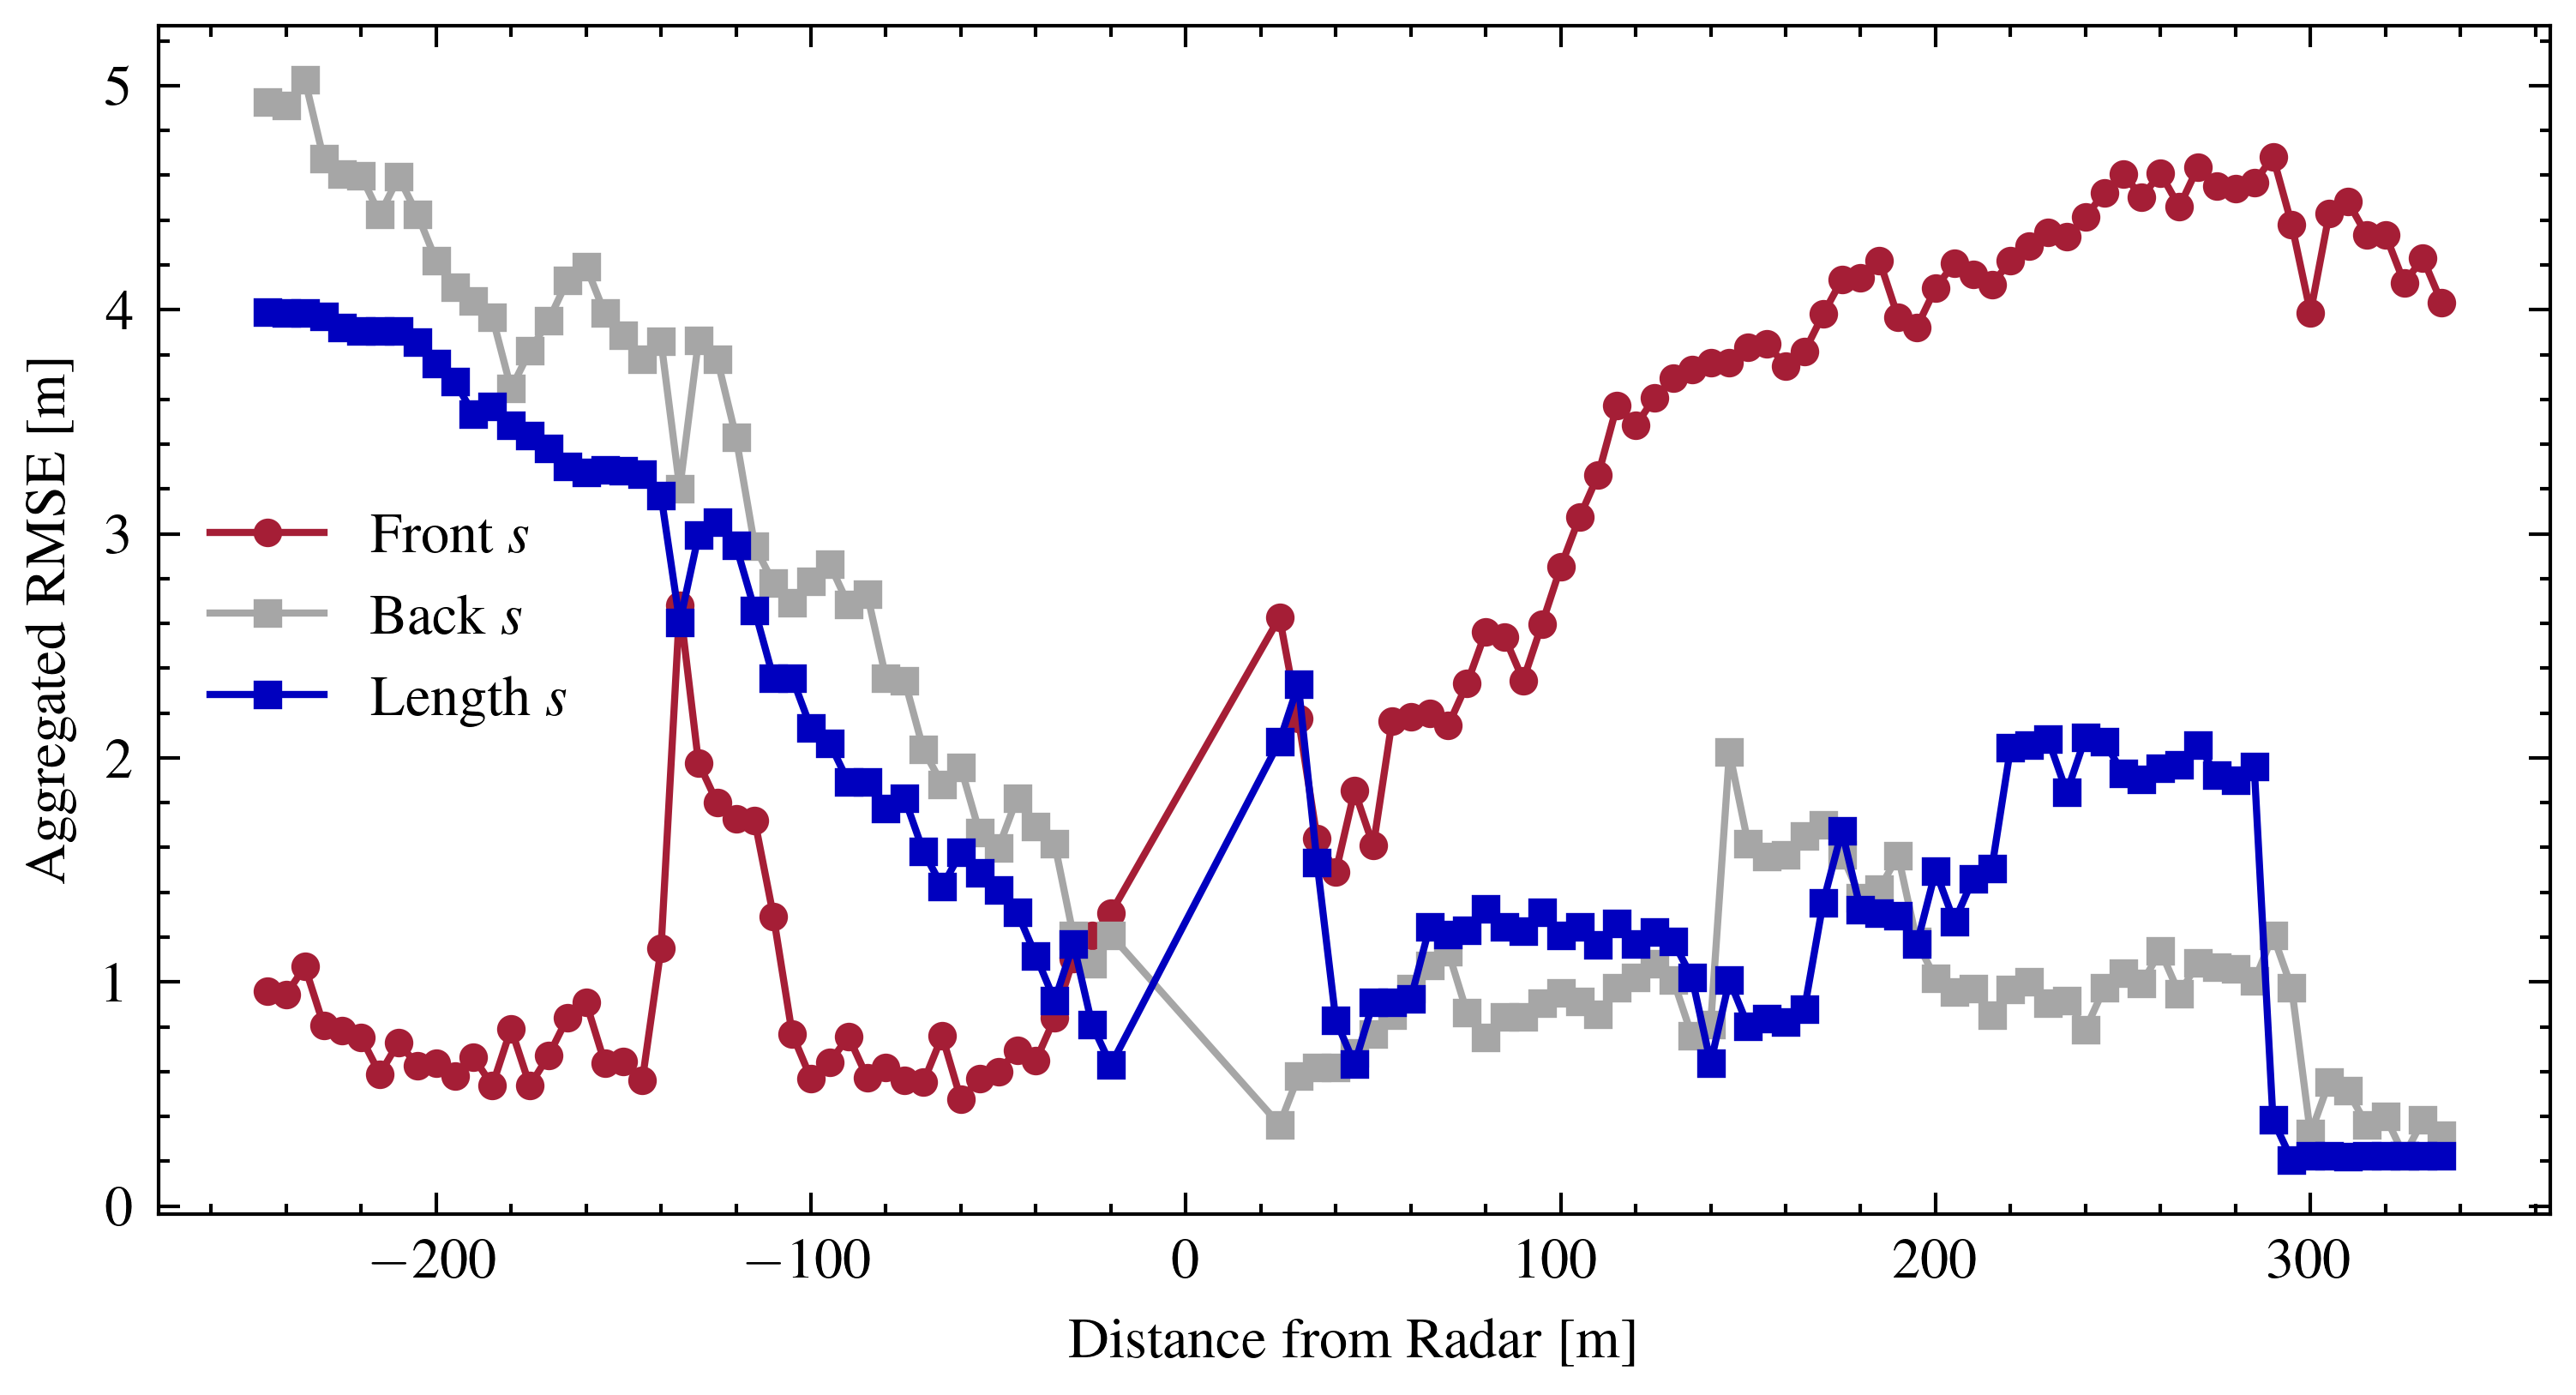

In [56]:
dist_error_ip = (
    raw_error_df.with_columns(
        pl.when(pl.col("approaching"))
        .then(pl.col("dist_raw") * -1)
        .otherwise(pl.col("dist_raw"))
        .alias("dist_raw")
    )
    .sort("dist_raw")
    .group_by_dynamic(
        index_column=(pl.col("dist_raw")).cast(int),
        every="5i",
    )
    .agg(
        pl.col("front_s_se").mean().sqrt(),
        pl.col("back_s_se").mean().sqrt(),
        pl.col("length_s_se").mean().sqrt(),
    )
    # .sort(
    #     [
    #         "ip",
    #     ]
    # )
    .to_pandas()
)

import matplotlib.pyplot as plt

# Import the scienceplots package to access the styles
import scienceplots as sp

# Load the science style
plt.style.use(["science", "ieee"])

# Assuming dist_error_ip is a Pandas DataFrame with the correct columns
# If not, you should convert it to a Pandas DataFrame first


engine_color = [0.65, 0.65, 0.65]
gps_color = [0, 0, 0.75]
plutron_color = [0, 0, 0]
alabama = [165, 30, 54]
alabama = [i / 255 for i in alabama]

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(6, 3))

# Plot the data with line and markers
ax.plot(
    dist_error_ip["dist_raw"],
    dist_error_ip["front_s_se"],
    label="Front $s$",
    marker="o",
    linestyle="-",
    linewidth=1,
    markersize=3,
    color=alabama,
)
ax.plot(
    dist_error_ip["dist_raw"],
    dist_error_ip["back_s_se"],
    label="Back $s$",
    marker="s",
    linestyle="-",
    linewidth=1,
    markersize=3,
    color=engine_color,
)
ax.plot(
    dist_error_ip["dist_raw"],
    dist_error_ip["length_s_se"],
    label="Length $s$",
    marker="s",
    linestyle="-",
    linewidth=1,
    markersize=3,
    color=gps_color,
)

# Set the x and y axis labels
ax.set_xlabel("Distance from Radar [m]")
ax.set_ylabel("Aggregated RMSE [m]")

# show the legend
ax.legend()

In [57]:
import pandas as pd


def latex_mapper(s: str) -> str:
    return {
        "d": "$d$ [m]",
        "s": "$s$ [m]",
        "xy": "$(x, y)$ [m]",
        "coverage": "Coverage [\%]",
        "None": "-",
        "speed": "$\mu$ [m/s]",
    }[s]


def split_and_capitalize(metric):
    parts = metric.split("_")
    if len(parts) == 3:
        return (parts[-1].upper(), parts[0].title(), latex_mapper(parts[1]))
    else:
        return (metric.title(), None, None)


pretty_df = (
    stacked_df.drop(
        cs.by_name("^.*_mse$"),
        cs.by_name("^.*sequences.*$"),
        "n_vehicles",
        "n_vehicles_per_sequence",
    )
    .with_columns(
        pl.col("average_coverage_percent") * 100,
    )
    .rename(
        {
            "s_rmse": "centroid_s_rmse",
            "speed_rmse": "Speed_speed_rmse",
            "d_rmse": "centroid_d_rmse",
        }
    )
)

pretty_df = (
    pretty_df.drop(["method", "lane"])
    .to_pandas()
    # make a multi index for the columns (top level is  Front/Back, second level is mse/rmse)
    .set_axis(
        pd.MultiIndex.from_tuples(
            [
                split_and_capitalize(col)
                for col in pretty_df.drop(["method", "lane"]).columns
            ],
            names=["Metric", "Location", "Frame"],
        ),
        axis=1,
    )
    .set_axis(
        pd.MultiIndex.from_frame(
            pretty_df[["lane", "method"]].to_pandas(),
            names=["Lane", "Method"],
        ),
        axis=0,
        # drop=True,
    )
    # .set_index(keys=[("Lane", pd.NA, pd.NA), ("Method", pd.NA, pd.NA,)], drop=True)
    .sort_index()
    .sort_index(axis=1)
)


pretty_df.head(20)

Metric            PERCENT         RMSE                                   \
Location          Average         Back               Centroid             
Frame       Coverage [\%] $(x, y)$ [m]   $s$ [m] $(x, y)$ [m]   $d$ [m]   
Lane Method                                                               
EBL1 ci         46.022595     1.914822  1.845234     2.085461  0.505375   
     imm        18.100286     1.809105  1.726938     1.989352  0.533264   
     raw        18.079417     1.794201  1.715689     1.895202  0.525645   
     smooth     46.022595     2.021814  1.981299     1.911965  0.405531   
EBL2 ci         71.098956     1.929777  1.895490     2.094938  0.365895   
     imm        17.193132     2.130033  2.057775     2.012664  0.557488   
     raw        18.097577     2.034908  1.950280     2.161276  0.585572   
     smooth     71.098956     2.119847  2.089926     1.728422  0.369645   
WBL1 ci         74.621968     1.807688  1.735643     1.763560  0.503428   
     imm        37.782204     2.192070  2.037800     2.092701  0.808060   
     raw        33.814608     2.206214  2.015521     2.237806  0.899053   
     smooth     74.621968     2.520485  2.477464     1.856177  0.482150   
WBL2 ci         70.665518     1.703926  1.634238     1.863626  0.478714   
     imm        27.283271     2.122269  1.994889     2.125603  0.724713   
     raw        25.875009     2.113535  1.960471     2.159677  0.792312   
     smooth     70.665518     1.953629  1.924588     1.481843  0.354915   

Metric                                                              
Location                     Front              Length       Speed  
Frame         $s$ [m] $(x, y)$ [m]   $s$ [m]   $s$ [m] $\mu$ [m/s]  
Lane Method                                                         
EBL1 ci      2.021799     3.336439  3.295444  1.787963    1.048504  
     imm     1.915229     3.200152  3.153206  2.940402    0.855211  
     raw     1.782787     3.325927  2.923540  1.907808    0.933500  
     smooth  1.867849     2.935328  2.903806  1.787963    1.049890  
EBL2 ci      2.061420     3.177237  3.152352  1.621620    0.931963  
     imm     1.933646     2.755828  2.695605  2.670017    0.846688  
     raw     1.816486     3.088122  2.623193  1.920565    0.949967  
     smooth  1.689915     2.152912  2.118649  1.621620    0.548405  
WBL1 ci      1.688981     2.795474  2.746960  1.303433    0.890416  
     imm     1.929679     3.002163  2.888682  2.895521    0.890716  
     raw     1.864113     3.262879  2.774690  1.725727    0.971536  
     smooth  1.795543     1.634439  1.560045  1.303433    0.477555  
WBL2 ci      1.798417     3.153101  3.112384  1.303976    1.147435  
     imm     1.996353     3.191740  3.104406  2.866944    1.124797  
     raw     1.895096     3.623457  2.925198  1.598092    1.251702  
     smooth  1.439642     2.074926  2.039758  1.303976    0.489449

In [58]:
import pandas as pd


def latex_mapper(s: str) -> str:
    return {
        "d": "$d$ [m]",
        "s": "$s$ [m]",
        "xy": "$(x, y)$ [m]",
        "coverage": "Coverage [\%]",
        "None": "-",
        "speed": "$\mu$ [m/s]",
    }[s]


def split_and_capitalize(metric):
    parts = metric.split("_")
    if len(parts) == 3:
        return (parts[-1].upper(), parts[0].title(), latex_mapper(parts[1]))
    else:
        return (metric.title(), None, None)


pretty_df = (
    stacked_summary_df.drop(
        cs.by_name("^.*_mse$"),
        cs.by_name("^.*sequences.*$"),
        "n_vehicles",
        "n_vehicles_per_sequence",
    )
    .with_columns(
        pl.col("average_coverage_percent") * 100,
    )
    .rename(
        {
            "s_rmse": "centroid_s_rmse",
            "speed_rmse": "Speed_speed_rmse",
            "d_rmse": "centroid_d_rmse",
        }
    )
    .group_by(["method"])
    .agg(pl.all().mean())
)

pretty_df = (
    pretty_df.drop(["method", "lane"])
    .to_pandas()
    # make a multi index for the columns (top level is  Front/Back, second level is mse/rmse)
    .set_axis(
        pd.MultiIndex.from_tuples(
            [
                split_and_capitalize(col)
                for col in pretty_df.drop(["method", "lane"]).columns
            ],
            names=["Metric", "Location", "Frame"],
        ),
        axis=1,
    )
    .set_axis(
        pd.MultiIndex.from_frame(
            pretty_df[["method"]].to_pandas(),
            names=["Method"],
        ),
        axis=0,
        # drop=True,
    )
    # .set_index(keys=[("Lane", pd.NA, pd.NA), ("Method", pd.NA, pd.NA,)], drop=True)
    .sort_index()
    .sort_index(axis=1)
)


pretty_df.head(20)

Metric         PERCENT         RMSE                                   \
Location       Average         Back               Centroid             
Frame    Coverage [\%] $(x, y)$ [m]   $s$ [m] $(x, y)$ [m]   $d$ [m]   
Method                                                                 
ci           68.766429     1.785605  1.707259     1.913396  0.480661   
imm          30.975969     2.037709  1.915695     2.052092  0.665949   
raw          28.846009     1.973259  1.833773     2.095809  0.703968   
smooth       68.766429     2.074547  2.026255     1.654123  0.416927   

Metric                                                          Sequence_Id  
Location                  Front              Length       Speed         NaN  
Frame      $s$ [m] $(x, y)$ [m]   $s$ [m]   $s$ [m] $\mu$ [m/s]         NaN  
Method                                                                       
ci        1.844017     3.062311  3.018489  1.331735    0.995675        10.0  
imm       1.929455     3.038030  2.952684  2.791715    0.917560        10.0  
raw       1.793341     3.343054  2.788027  1.690242    1.013324        10.0  
smooth    1.592170     2.058483  2.002678  1.331735    0.583843        10.0

In [59]:
print(
    pretty_df.to_latex(
        sparsify=True, float_format="%.2f", index_names=["Lane", "Method"]
    )
)

\begin{tabular}{lrrrrrrrrrrr}
\toprule
Metric & PERCENT & \multicolumn{9}{r}{RMSE} & Sequence_Id \\
Location & Average & \multicolumn{2}{r}{Back} & \multicolumn{3}{r}{Centroid} & \multicolumn{2}{r}{Front} & Length & Speed & NaN \\
Frame & Coverage [\%] & $(x, y)$ [m] & $s$ [m] & $(x, y)$ [m] & $d$ [m] & $s$ [m] & $(x, y)$ [m] & $s$ [m] & $s$ [m] & $\mu$ [m/s] & NaN \\
Method &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
ci & 68.77 & 1.79 & 1.71 & 1.91 & 0.48 & 1.84 & 3.06 & 3.02 & 1.33 & 1.00 & 10.00 \\
imm & 30.98 & 2.04 & 1.92 & 2.05 & 0.67 & 1.93 & 3.04 & 2.95 & 2.79 & 0.92 & 10.00 \\
raw & 28.85 & 1.97 & 1.83 & 2.10 & 0.70 & 1.79 & 3.34 & 2.79 & 1.69 & 1.01 & 10.00 \\
smooth & 68.77 & 2.07 & 2.03 & 1.65 & 0.42 & 1.59 & 2.06 & 2.00 & 1.33 & 0.58 & 10.00 \\
\bottomrule
\end{tabular}



In [60]:
smoothed_error_df.group_by(["sequence_id", "vehicle_id"]).agg(
    pl.col("^.*_se$").mean().name.map(lambda x: f"{x.replace('_se', '')}_mse"),
    pl.col("^.*_se$").mean().sqrt().name.map(lambda x: f"{x.replace('_se', '')}_rmse"),
    pl.col("^.*_pearsonr$").first(),
).sort("front_s_mse", descending=True).head(10)

shape: (10, 29)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ sequence_ ┆ vehicle_i ┆ front_s_m ┆ s_velocit ┆ … ┆ speed_pea ┆ s_pearson ┆ length_s_ ┆ d_pearso │
│ id        ┆ d         ┆ se        ┆ y_mse     ┆   ┆ rsonr     ┆ r         ┆ pearsonr  ┆ nr       │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ u32       ┆ u64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 12        ┆ 3086      ┆ 10.877886 ┆ 0.496851  ┆ … ┆ 0.99152   ┆ 0.999985  ┆ NaN       ┆ 0.976927 │
│ 14        ┆ 1709      ┆ 8.331082  ┆ 0.351902  ┆ … ┆ 0.99152   ┆ 0.999985  ┆ NaN       ┆ 0.976927 │
│ 14        ┆ 1396      ┆ 8.056848  ┆ 2.149323  ┆ … ┆ 0.99152   ┆ 0.999985  ┆ NaN       ┆ 0.976927 │
│ 12        ┆ 687       ┆ 7.705304  ┆ 0.555737  ┆ … ┆ 0.99152   ┆ 0.999985  ┆ NaN       ┆ 0.976927 │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 15        ┆ 339       ┆ 5.22232   ┆ 0.517168  ┆ … ┆ 0.99152   ┆ 0.999985  ┆ NaN       ┆ 0.976927 │
│ 8         ┆ 1870      ┆ 4.718525  ┆ 0.167517  ┆ … ┆ 0.99152   ┆ 0.999985  ┆ NaN       ┆ 0.976927 │
│ 13        ┆ 803       ┆ 3.255266  ┆ 0.406553  ┆ … ┆ 0.99152   ┆ 0.999985  ┆ NaN       ┆ 0.976927 │
│ 3         ┆ 1856      ┆ 2.619688  ┆ 0.278095  ┆ … ┆ 0.99152   ┆ 0.999985  ┆ NaN       ┆ 0.976927 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [61]:
import pandas as pd
import polars.selectors as cs

smoothed_error_df = error_df.filter(
    pl.col("vehicle_id").cum_count().over(["epoch_time", "vehicle_id", "object_id"]) < 1
)

raw_error_df = (
    smoothed_error_df.pipe(
        element_error,
        true_col="front_s",
        pred_col="front_s_raw",
    )
    .pipe(
        element_error,
        true_col="s_velocity",
        pred_col="s_velocity_raw",
    )
    .pipe(
        element_error,
        true_col="back_s",
        pred_col="back_s_raw",
    )
    .pipe(
        element_error,
        true_col="speed",
        pred_col="speed_raw",
    )
    .with_columns(
        (
            (pl.col(f"{loc}_x") - pl.col(f"{loc}_x_raw")).pow(2)
            + (pl.col(f"{loc}_y") - pl.col(f"{loc}_y_raw")).pow(2)
        ).alias(f"{loc}_xy_se")
        for loc in ["front", "back"]
    )
)

grouped_raw_error_df = (
    raw_error_df.group_by(["lane", "lane_index"])
    .agg(
        pl.col("^.*_se$").mean().name.map(lambda x: f"{x.replace('_se', '')}_mse"),
        pl.col("^.*_se$")
        .mean()
        .sqrt()
        .name.map(lambda x: f"{x.replace('_se', '')}_rmse"),
        pl.col("^.*_ae$").mean().name.map(lambda x: f"{x.replace('_ae', '')}_mae"),
        pl.col("^.*_pearsonr$").first(),
        ((pl.col("raw_trajectory_length") / pl.col("sequence_distance")).mean()).alias(
            "average_coverage_percent"
        ),
        pl.col("sequence_id").n_unique().alias("n_sequences"),
        pl.col("object_id").n_unique().alias("n_vehicles"),
    )
    .with_columns(
        pl.concat_str(
            pl.col("lane").str.slice(0, 3), (pl.col("lane_index") + 1).cast(str)
        ).alias("lane"),
    )
    .drop(
        "lane_index",
        cs.by_name("^s_velocity_.*$"),
        cs.by_name("^.*_ae$"),
        cs.by_name("^.*_pearsonr$"),
    )
)

ValueError: array must not contain infs or NaNs

In [ ]:
grouped_raw_error_df = (
    raw_error_df.group_by("sequence_id")
    .agg(
        pl.col("^.*_se$").mean().name.map(lambda x: f"{x.replace('_se', '')}_mse"),
        pl.col("^.*_se$")
        .mean()
        .sqrt()
        .name.map(lambda x: f"{x.replace('_se', '')}_rmse"),
        pl.col("^.*_ae$").mean().name.map(lambda x: f"{x.replace('_ae', '')}_mae"),
        pl.col("^.*_pearsonr$").first(),
        pl.col("lane").first(),
        pl.col("lane_index").first(),
    )
    .with_columns(
        pl.concat_str(
            pl.col("lane").str.slice(0, 3), (pl.col("lane_index") + 1).cast(str)
        ).alias("lane"),
    )
    .drop(
        "lane_index",
        cs.by_name("^s_velocity_.*$"),
        cs.by_name("^.*_ae$"),
        cs.by_name("^.*_pearsonr$"),
    )
)


# pretty_df.style.highlight_min(axis=1, props="font-weight:bold;")

print(pretty_df.to_latex(sparsify=True, float_format="%.2f"))

## Plots of Position Vs. Time

In [ ]:
veh_df.filter((pl.col("lane") == "EBL1") & (pl.col("lane_index") == 0))[
    "sequence_id"
].value_counts()

In [ ]:
target_sequence = 14

In [ ]:
from src.plotting.time_space import plot_time_space
from datetime import timedelta


s_low = 850
s_high = 1250

fig = go.Figure()

plot_veh_df = veh_df.filter(
    (pl.col("sequence_id") == target_sequence)
    & pl.col("front_s").is_between(s_low, s_high)
).with_columns(
    (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
    # ((s_high - pl.col('front_s'))).alias('front_s')
)

fig.add_trace(
    go.Scatter(
        x=plot_veh_df["epoch_time_cst"].cast(str),
        y=plot_veh_df["front_s"],
        mode="markers",
        name="GPS",
        marker_color="red",
        marker_size=10,
    ),
)


plot_radar_df = processed_radar_df.filter(
    pl.col("epoch_time").is_between(
        plot_veh_df["epoch_time"].min()
        - timedelta(minutes=0.05, seconds=-1 * optimal_offset),
        plot_veh_df["epoch_time"].max()
        + timedelta(minutes=0.05, seconds=optimal_offset),
    )
    # & (pl.col("lane") == "EBL1")
    # & (pl.col('lane_index') == 0)
    & (pl.col("front_s_smooth").is_between(s_low, s_high))
).with_columns(
    pl.when(pl.col("lane").str.contains("W"))
    .then((s_high - pl.col("front_s_smooth")) + s_low)
    .otherwise(pl.col("front_s_smooth"))
    .alias("front_s_smooth"),
    pl.col("epoch_time").dt.convert_time_zone("US/Central").alias("epoch_time_cst"),
)


for lane, lane_index, color in [
    ("EBL1", 0, "black"),
    ("EBL1", 1, "darkgrey"),
    # ("WBL1", 0, "crimson"),
    # ("WBL1", 1, "pink"),
]:
    fig.add_trace(
        go.Scatter(
            x=plot_radar_df.filter(
                (pl.col("lane") == lane) & (pl.col("lane_index") == lane_index)
            )["epoch_time_cst"].cast(str),
            y=plot_radar_df.filter(
                (pl.col("lane") == lane) & (pl.col("lane_index") == lane_index)
            )["front_s_smooth"],
            mode="markers",
            name=f"{lane[:-1]}{lane_index + 1}",
            marker_color=color,
            marker_size=5,
        ),
    )


# fig = plot_time_space(
#     plot_radar_df.with_columns(
#         pl.col("epoch_time").dt.convert_time_zone("US/Central").alias("epoch_time_cst"),
#         # (s_high - pl.col('ci_front_s')).alias('ci_front_s')
#     ).sort('epoch_time_cst'),
#     # .filter(
#     #     pl.col('lane_index') == 0
#     # ),
#     s_col="front_s_smooth",
#     markers=True,
#     vehicle_col="vehicle_id",
#     color_func=lambda df, i: "black" if df["lane"].str.contains("EBL1").any() else "grey",
#     fig=fig,
#     every=10,
#     # marker_style='circle',
# )


# fig = plot_time_space(
#     plot_radar_df.with_columns(
#         pl.col('epoch_time').dt.convert_time_zone('US/Central').alias('epoch_time_cst'),
#         # (s_high - pl.col('ci_front_s')).alias('ci_front_s')
#     ).filter(
#         pl.col('lane_index') == 1
#     ),
#     s_col='ci_front_s',
#     markers=True,
#     vehicle_col='vehicle_id',
#     fig=fig,
#     marker_style='triangle',
# )


fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # set the x_limit
    xaxis=dict(
        range=[
            plot_radar_df["epoch_time_cst"].min(),
            plot_radar_df["epoch_time_cst"].max(),
        ],
    ),
    yaxis=dict(
        # range=[200, 1500],
        title="S Distance [m]",
        autorange="reversed",
    ),
    # set the size of the figure
    width=1000,
    height=600,
)


fig.show()

In [ ]:
from src.plotting.time_space import plot_time_space
from datetime import timedelta

from plotly.subplots import make_subplots

target_sequence = 13

t_low = "2023-10-31 12:06:25"
t_high = "2023-10-31 12:06:40"

s_low = 350
s_high = 600

fig = go.Figure()


plot_veh_df = (
    veh_df.filter(
        (pl.col("sequence_id") == target_sequence)
        & pl.col("front_s").is_between(s_low, s_high)
    )
    .with_columns(
        (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
        .dt.convert_time_zone("US/Central")
        .alias("epoch_time_cst"),
        # ((s_high - pl.col('front_s'))).alias('front_s')
    )
    .filter(
        pl.col("epoch_time_cst").is_between(
            pl.lit(t_low).str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
            pl.lit(t_high).str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
        )
    )
)

fig.add_trace(
    go.Scatter(
        x=plot_veh_df["epoch_time_cst"].cast(str),
        y=plot_veh_df["front_s"],
        mode="markers",
        name="GPS",
        marker_color="red",
        marker_size=5,
        showlegend=False,
    ),
)


plot_radar_df = processed_radar_df.with_columns(
    # pl.when(pl.col("lane").str.contains("W"))
    # .then((s_high - pl.col("front_s_smooth")) + s_low)
    # .otherwise(pl.col("front_s_smooth"))
    # .alias("front_s_smooth"),
    pl.col("epoch_time")
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
).filter(
    pl.col("epoch_time_cst").is_between(
        pl.lit(t_low).str.strptime(
            pl.Datetime(time_unit="ns", time_zone="US/Central"),
        ),
        pl.lit(t_high).str.strptime(
            pl.Datetime(time_unit="ns", time_zone="US/Central"),
        ),
    )
)


for lane, lane_index, color in [
    ("WBL1", 1, "black"),
    ("WBL1", 0, "grey"),
    # ("WBL1", 0, "crimson"),
    # ("WBL1", 1, "pink"),
]:
    fig.add_trace(
        go.Scatter(
            x=plot_radar_df.filter(
                (pl.col("lane") == lane) & (pl.col("lane_index") == lane_index)
            )["epoch_time_cst"].cast(str),
            y=plot_radar_df.filter(
                (pl.col("lane") == lane) & (pl.col("lane_index") == lane_index)
            )["front_s_smooth"],
            mode="markers",
            name=f"{lane[:-1]}{lane_index + 1}",
            marker_color=color,
            marker_size=3,
        ),
    )


fig = fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # set the x_limit
    xaxis=dict(
        range=[
            plot_radar_df["epoch_time_cst"].min(),
            plot_radar_df["epoch_time_cst"].max(),
        ],
    ),
    yaxis=dict(
        range=[s_low, s_high],
        title="S Distance [m]",
        # autorange="reversed",
    ),
    # set the size of the figure
    width=700,
    height=300,
    # ggplot2
    template="ggplot2",
    # set the margins to 0
    margin=dict(l=0, r=0, t=0, b=0),
)


fig.show()

In [62]:
from src.plotting.time_space import plot_time_space
from datetime import timedelta

from plotly.subplots import make_subplots

target_sequence = 13

s_low = 300
s_high = 1400

fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.5, 0.5],
    specs=[
        [{"type": "xy", "secondary_y": False}],
        [{"type": "xy", "secondary_y": True}],
    ],
)


plot_veh_df = veh_df.filter(
    (pl.col("sequence_id") == target_sequence)
    & pl.col("front_s").is_between(s_low, s_high)
).with_columns(
    (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
    # ((s_high - pl.col('front_s'))).alias('front_s')
)

fig.add_trace(
    go.Scatter(
        x=plot_veh_df["epoch_time_cst"].cast(str),
        y=plot_veh_df["front_s"],
        mode="markers",
        name="GPS",
        marker_color="red",
        marker_size=5,
    ),
    row=1,
    col=1,
)


plot_radar_df = processed_radar_df.filter(
    pl.col("epoch_time").is_between(
        plot_veh_df["epoch_time"].min()
        - timedelta(minutes=0, seconds=-1 * optimal_offset),
        plot_veh_df["epoch_time"].max() + timedelta(minutes=0, seconds=optimal_offset),
    )
    # & (pl.col("lane") == "EBL1")
    # & (pl.col('lane_index') == 0)
    & (pl.col("front_s_smooth").is_between(s_low, s_high))
).with_columns(
    # pl.when(pl.col("lane").str.contains("W"))
    # .then((s_high - pl.col("front_s_smooth")) + s_low)
    # .otherwise(pl.col("front_s_smooth"))
    # .alias("front_s_smooth"),
    pl.col("epoch_time")
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
)


for lane, lane_index, color in [
    ("WBL1", 1, "black"),
    ("WBL1", 0, "crimson"),
    # ("WBL1", 1, "lightgrey"),
    # ("WBL1", 0, "crimson"),
    # ("WBL1", 1, "pink"),
]:
    fig.add_trace(
        go.Scatter(
            x=plot_radar_df.filter(
                (pl.col("lane") == lane) & (pl.col("lane_index") == lane_index)
            )["epoch_time_cst"].cast(str),
            y=plot_radar_df.filter(
                (pl.col("lane") == lane) & (pl.col("lane_index") == lane_index)
            )["front_s_smooth"],
            mode="markers",
            name=f"{lane[:-1]}{lane_index + 1}",
            marker_color=color,
            marker_size=2,
        ),
        row=1,
        col=1,
    )


fig = fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # set the x_limit
    xaxis=dict(
        range=[
            plot_radar_df["epoch_time_cst"].min(),
            plot_radar_df["epoch_time_cst"].max(),
        ],
    ),
    yaxis=dict(
        # range=[200, 1500],
        title="S Distance [m]",
        # autorange="reversed",
    ),
    # set the size of the figure
    width=1600,
    height=800,
    # ggplot2
    template="ggplot2",
)

plot_error_df = error_df.filter(
    (
        pl.col("sequence_id")
        == target_sequence  # & pl.col("front_s").is_between(850, 1250)
    )
).with_columns(
    pl.col("epoch_time").dt.convert_time_zone("US/Central").alias("epoch_time_cst"),
)


plot_veh_df = veh_df.filter(
    (
        pl.col("sequence_id")
        == target_sequence  # & pl.col("front_s").is_between(850, 1250)
    )
).with_columns(
    (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
    # ((s_high - pl.col('front_s'))).alias('front_s')
)

setup = [
    ("dGPS", "s_velocity", False, "red", 5),
    ("CI", "ci_s_velocity", False, "blue", 3),
    ("Raw", "s_velocity_raw", False, "black", 3),
    ("RTS", "s_velocity_smooth", False, "purple", 3),
]
row_mod = 1

for i, (name, col, secondary_y, color, size) in enumerate(setup):
    plot_df = plot_veh_df if name == "dGPS" else plot_error_df

    fig.add_trace(
        go.Scatter(
            x=plot_df["epoch_time_cst"].cast(str),
            y=plot_df[col],
            mode="markers",
            name=name,
            marker=dict(color=color, size=size),
            showlegend=(i > 0),
            # line=dict(color=color, dash="solid" if secondary_y else "dot"),
        ),
        secondary_y=secondary_y,
        row=row_mod + 1,
        col=1,
    )

fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # update the subplot titles
    title_font_family="Times New Roman",
    title_font_size=44,
    # set the x_limit
    yaxis=dict(
        title="S Distance [m]",
    ),
    yaxis2=dict(
        title="S Velocity [m/s]",
    ),
    # yaxis3=dict(
    #     title="D Distance [m/s]",
    # ),
    # yaxis4=dict(
    #     title="D Velocity [m/s]",
    # ),
    # set the size of the figure
    # width=1000,
    # height=600,
    template="ggplot2",
    # set the margin to reduce the whitespace
    margin=dict(l=0, r=0, t=0, b=0),
    # put the legend on the bottom
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            family="Times New Roman",
            size=22,
        ),
    ),
)
fig.show()

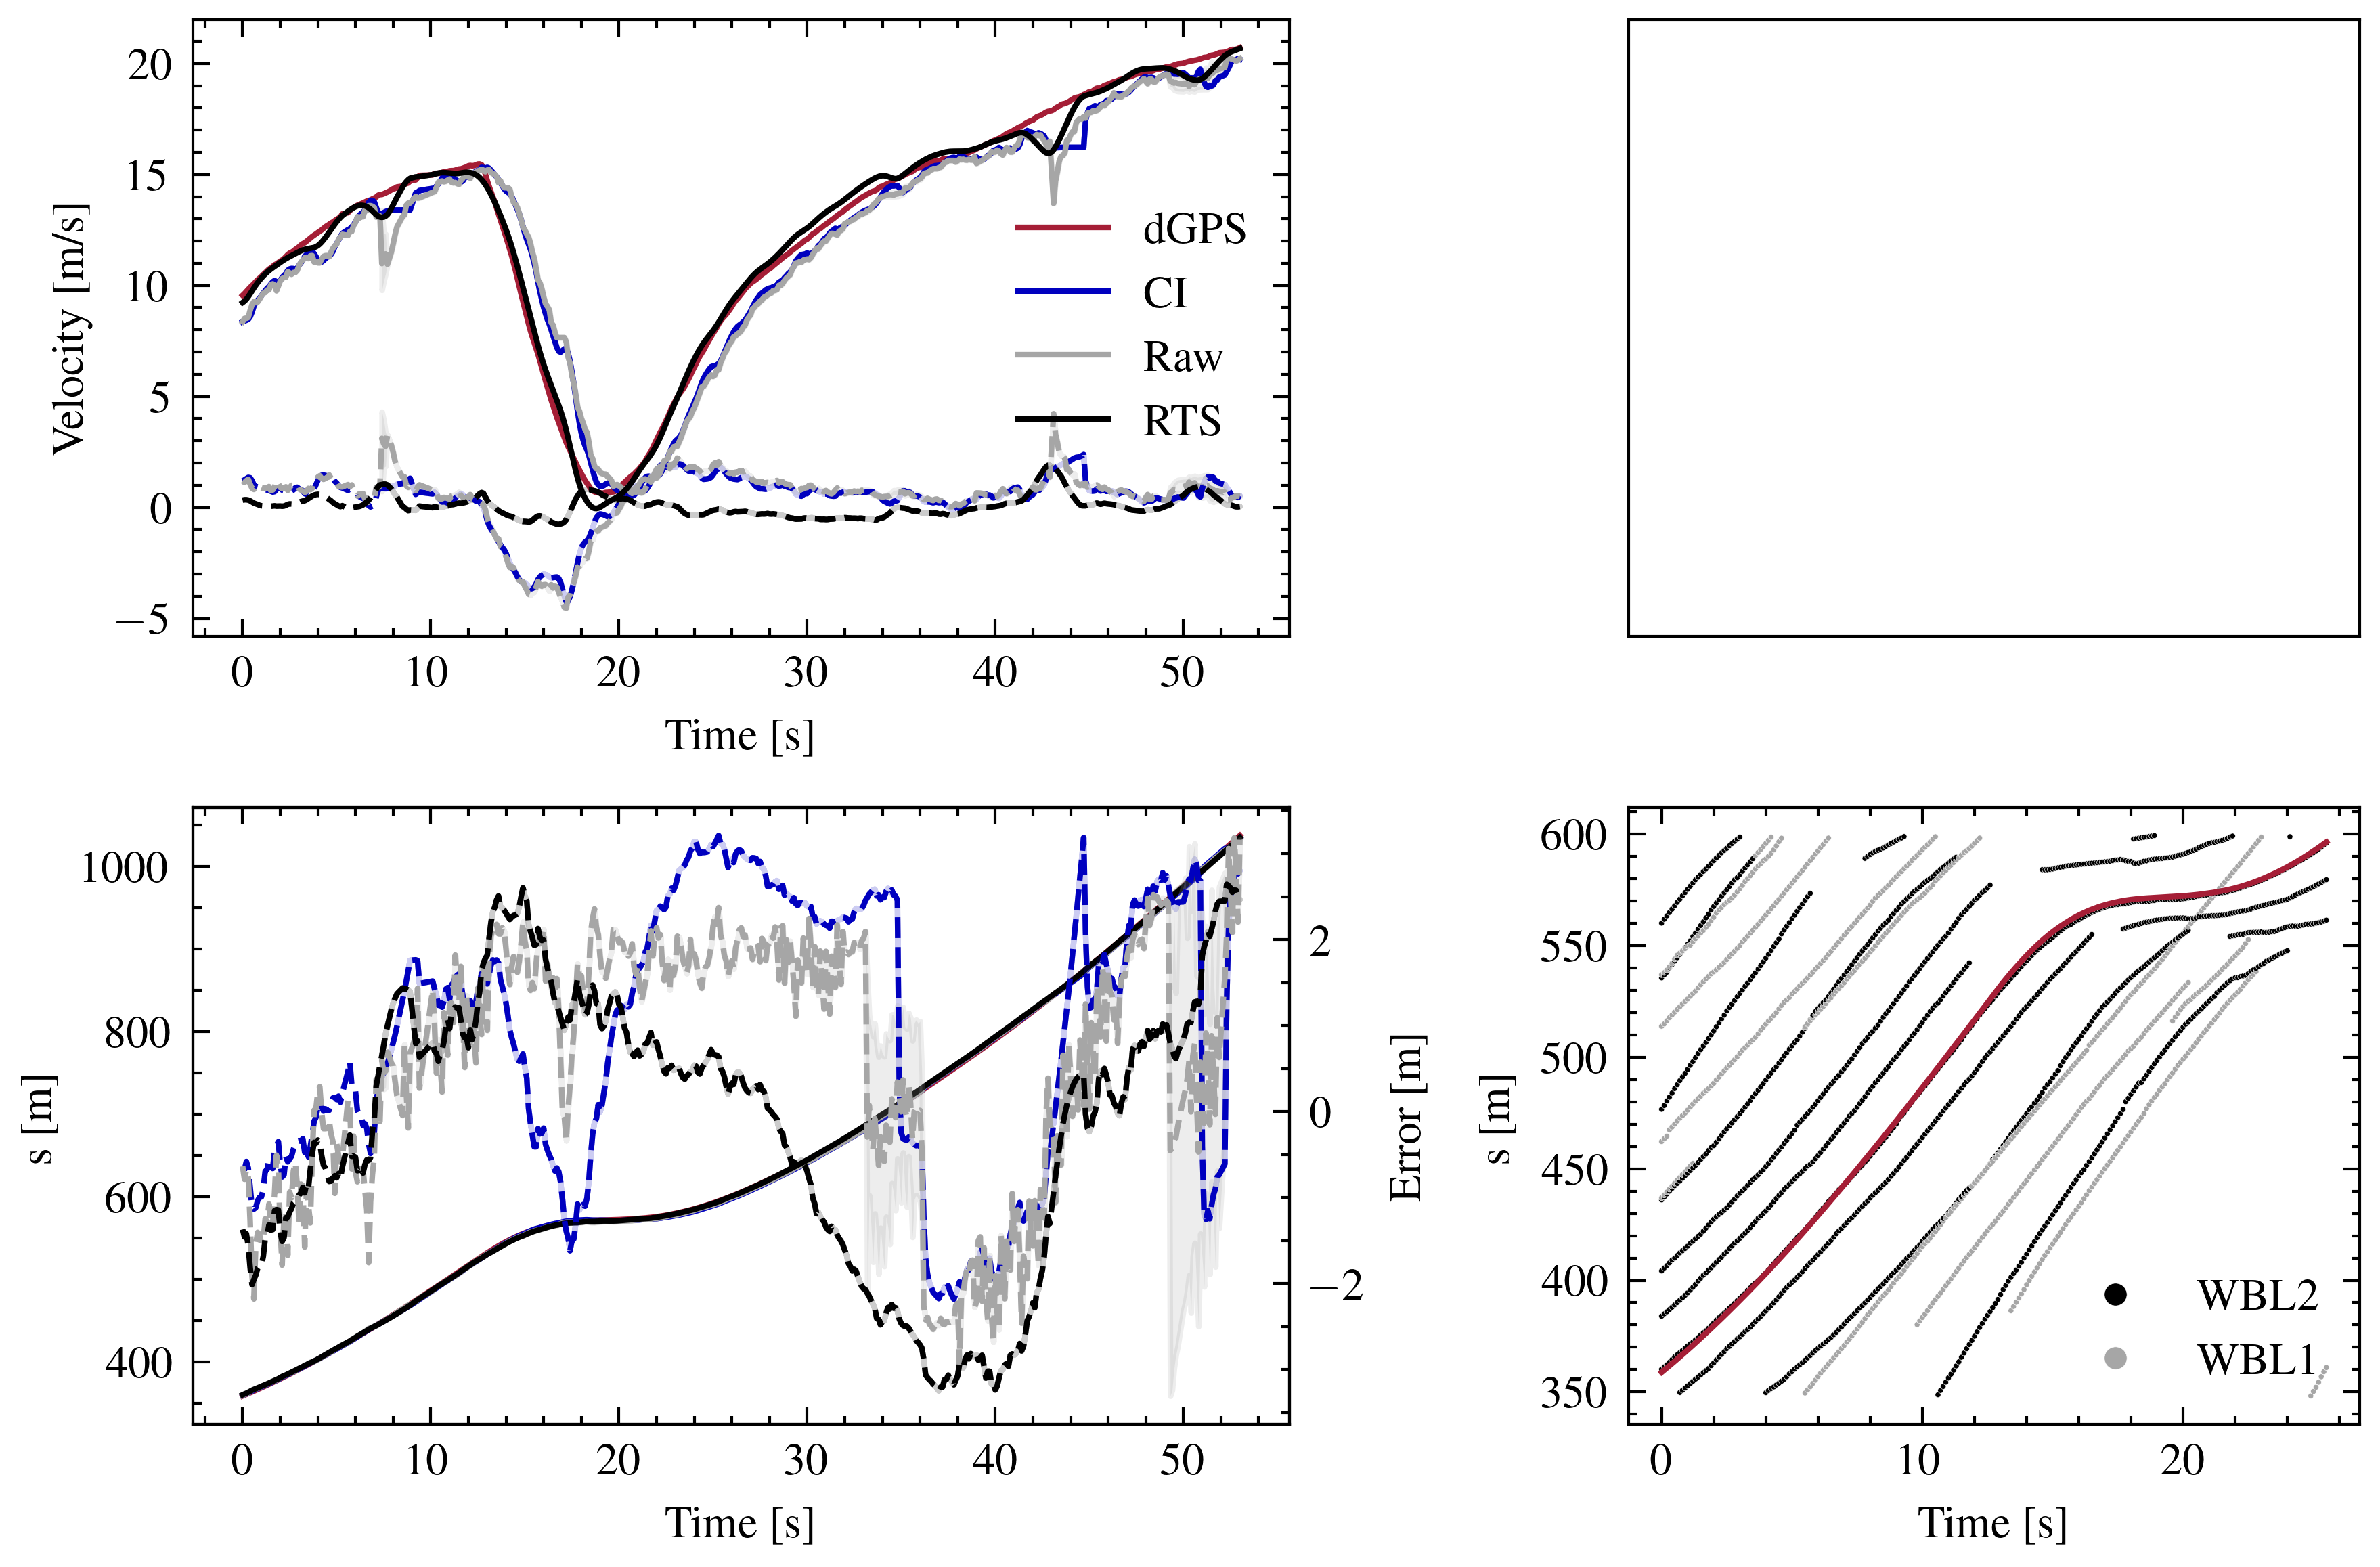

In [66]:
import seaborn as sns

target_sequence = 13

s_low = 350
s_high = 600

fig, (ax1, ax2) = plt.subplots(
    2,
    2,
    width_ratios=[3, 2],
    figsize=(6, 4),
)

# remove the ticks
# for a in ax1[:-1]:
ax1[-1].set_xticks([])
ax1[-1].set_yticks([])



plot_error_df = (
    error_df.filter(
        (pl.col("sequence_id") == target_sequence) & (pl.col("vehicle_id") == 1224)
    )
    .with_columns(
        pl.col("epoch_time").dt.convert_time_zone("US/Central").alias("epoch_time_cst"),
    )
    .with_columns(
        ((pl.col("epoch_time_cst") - pl.col("epoch_time_cst").min()).dt.total_milliseconds() / 1000).alias('time')
    )
    # .gather_every(10)
)

plot_veh_df = (
    veh_df.filter((pl.col("sequence_id") == target_sequence))
    .with_columns(
        (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
        .dt.convert_time_zone("US/Central")
        .alias("epoch_time_cst"),
    )
    .filter(
        pl.col("epoch_time_cst").is_between(
            plot_error_df["epoch_time_cst"].min(),
            plot_error_df["epoch_time_cst"].max(),
        )
    )
    .with_columns(
        ((pl.col("epoch_time_cst") - plot_error_df["epoch_time_cst"].min()).dt.total_milliseconds() / 1000).alias('time')
    )
)


small_s_veh_df = plot_veh_df.filter(pl.col("front_s").is_between(s_low, s_high))

plot_radar_df = (
    processed_radar_df.sort("epoch_time")
    .with_columns(
        # pl.when(pl.col("lane").str.contains("W"))
        # .then((s_high - pl.col("front_s_smooth")) + s_low)
        # .otherwise(pl.col("front_s_smooth"))
        # .alias("front_s_smooth"),
        pl.col("epoch_time")
        .dt.convert_time_zone("US/Central")
        .alias("epoch_time_cst"),
    )
    .filter(
        pl.col("epoch_time_cst").is_between(
            small_s_veh_df["epoch_time_cst"].min(),
            small_s_veh_df["epoch_time_cst"].max(),
        )
        & (pl.col("front_s_smooth").is_between(s_low, s_high))
        & pl.col("lane").str.contains("W")
    )
    .with_columns(
        ((pl.col("epoch_time_cst") - plot_error_df["epoch_time_cst"].min()).dt.total_milliseconds() / 1000).alias('time')
    )
)

sns.lineplot(
    small_s_veh_df,
    x="time",
    y="s",
    color=alabama,
    # s=1,
    ax=ax2[1],
)

sns.scatterplot(
    plot_radar_df.select(["time", "s_smooth", "lane_index"]).with_columns(pl.col('lane_index').replace({0: 
    "WBL1", 1: 'WBL2'})),
    x="time",
    y="s_smooth",
    s=1,
    hue="lane_index",
    palette=[plutron_color, engine_color, ],
    ax=ax2[1],
)

# # update the legend. 
handles, labels = ax2[1].get_legend_handles_labels()
ax2[1].legend(handles=handles, labels=labels, markerscale=4)

j = 0
for setup, axes, true_col in zip(
    [
        [
            ("dGPS", "s_velocity", alabama, 5),
            ("CI", "ci_s_velocity", gps_color, 3),
            ("Raw", "s_velocity_raw", engine_color, 3),
            ("RTS", "s_velocity_smooth", plutron_color, 3),
        ],
        [
            ("dGPS", "s", alabama, 5),
            ("CI", "ci_s", gps_color, 3),
            ("Raw", "s_raw", engine_color, 3),
            ("RTS", "s_smooth", plutron_color, 3),
        ],
    ],
    [ax1, ax2],
    ["s_velocity", "s"],
):
    if true_col == "s":
        mew_ax = axes[0].twinx()
    else:
        mew_ax = axes[0]

    for i, (name, col, color, size) in enumerate(setup):
        plot_df = plot_veh_df if name == "dGPS" else plot_error_df

        plot_df = plot_df.with_columns((pl.col(true_col) - pl.col(col)).alias("error"))

        plot_ = sns.lineplot(
            data=plot_df,
            x="time",
            y=col,
            color=color,
            # s=size,
            label=name if j == 0 else None,
            ax=axes[0],
        )

        # if j == 0:
        #     for ind, label in enumerate(plot_.get_xticklabels()):
        #         if ind % 2 == 0:  # every 10th label is kept
        #             label.set_visible(True)
        #         else:
        #             label.set_visible(False)

        if name != "dGPS":
            sns.lineplot(
                data=plot_df,
                x="time",
                y="error",
                color=color,
                # s=size,
                label=None,
                ax=mew_ax,
                linestyle="--",
                # showlegend=False,
            )

    j += 1

ax1[0].sharex(ax2[0])
# only keep some of the ticks
ax1[0].set_ylabel("Velocity [m/s]")
ax2[0].set_ylabel("s [m]")
mew_ax.set_ylabel("Error [m]")
ax2[1].set_ylabel('s [m]')

# set all the x-labels as Time [s]
ax1[0].set_xlabel("Time [s]")
ax2[0].set_xlabel("Time [s]")
ax2[1].set_xlabel("Time [s]")

# turn off ax[1] xaxis
# ax1[0].set_xlabel("")
# ax1[0].set_xticklabels([])

plt.tight_layout()

In [64]:
plot_df['vehicle_id'].unique()

shape: (2,)
Series: 'vehicle_id' [u64]
[
	803
	1224
]

In [ ]:
handles

In [ ]:
from src.plotting.time_space import plot_time_space
from datetime import timedelta

from plotly.subplots import make_subplots

target_sequence = 13

s_low = 0
s_high = 1600

fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.5, 0.5],
    specs=[
        [{"type": "xy", "secondary_y": False}],
        [{"type": "xy", "secondary_y": True}],
    ],
)


plot_veh_df = veh_df.filter(
    (pl.col("sequence_id") == target_sequence)
    & pl.col("front_s").is_between(s_low, s_high)
).with_columns(
    (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
    # ((s_high - pl.col('front_s'))).alias('front_s')
)

fig.add_trace(
    go.Scatter(
        x=plot_veh_df["epoch_time_cst"].cast(str),
        y=plot_veh_df["front_s"],
        mode="markers",
        name="GPS",
        marker_color="red",
        marker_size=5,
    ),
    row=1,
    col=1,
)


plot_radar_df = processed_radar_df.filter(
    pl.col("epoch_time").is_between(
        plot_veh_df["epoch_time"].min()
        - timedelta(minutes=0, seconds=-1 * optimal_offset),
        plot_veh_df["epoch_time"].max() + timedelta(minutes=0, seconds=optimal_offset),
    )
    # & (pl.col("lane") == "EBL1")
    # & (pl.col('lane_index') == 0)
    & (pl.col("front_s_smooth").is_between(s_low, s_high))
).with_columns(
    # pl.when(pl.col("lane").str.contains("W"))
    # .then((s_high - pl.col("front_s_smooth")) + s_low)
    # .otherwise(pl.col("front_s_smooth"))
    # .alias("front_s_smooth"),
    pl.col("epoch_time")
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
)


for lane, lane_index, color in [
    ("EBL1", 0, "black"),
    # ("WBL1", 1, "lightgrey"),
    # ("WBL1", 0, "crimson"),
    # ("WBL1", 1, "pink"),
]:
    fig.add_trace(
        go.Scatter(
            x=plot_radar_df.filter(
                (pl.col("lane") == lane) & (pl.col("lane_index") == lane_index)
            )["epoch_time_cst"].cast(str),
            y=plot_radar_df.filter(
                (pl.col("lane") == lane) & (pl.col("lane_index") == lane_index)
            )["front_s_smooth"],
            mode="markers",
            name=f"{lane[:-1]}{lane_index + 1}",
            marker_color=color,
            marker_size=2,
        ),
        row=1,
        col=1,
    )


fig = fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # set the x_limit
    xaxis=dict(
        range=[
            plot_radar_df["epoch_time_cst"].min(),
            plot_radar_df["epoch_time_cst"].max(),
        ],
    ),
    yaxis=dict(
        # range=[200, 1500],
        title="S Distance [m]",
        # autorange="reversed",
    ),
    # set the size of the figure
    width=1600,
    height=800,
    # ggplot2
    template="ggplot2",
)

plot_error_df = error_df.filter(
    (
        pl.col("sequence_id")
        == target_sequence  # & pl.col("front_s").is_between(850, 1250)
    )
).with_columns(
    pl.col("epoch_time").dt.convert_time_zone("US/Central").alias("epoch_time_cst"),
)


plot_veh_df = veh_df.filter(
    (
        pl.col("sequence_id")
        == target_sequence  # & pl.col("front_s").is_between(850, 1250)
    )
).with_columns(
    (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
    # ((s_high - pl.col('front_s'))).alias('front_s')
)

setup = [
    ("dGPS", "s_velocity", False, "red", 5),
    ("CI", "ci_s_velocity", False, "blue", 3),
    ("Raw", "s_velocity_raw", False, "black", 3),
    ("RTS", "s_velocity_smooth", False, "purple", 3),
]
row_mod = 1

for i, (name, col, secondary_y, color, size) in enumerate(setup):
    plot_df = plot_veh_df if name == "dGPS" else plot_error_df

    fig.add_trace(
        go.Scatter(
            x=plot_df["epoch_time_cst"].cast(str),
            y=plot_df[col],
            mode="markers",
            name=name,
            marker=dict(color=color, size=size),
            showlegend=(i > 0),
            # line=dict(color=color, dash="solid" if secondary_y else "dot"),
        ),
        secondary_y=secondary_y,
        row=row_mod + 1,
        col=1,
    )

fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # update the subplot titles
    title_font_family="Times New Roman",
    title_font_size=44,
    # set the x_limit
    yaxis=dict(
        title="S Distance [m]",
    ),
    yaxis2=dict(
        title="S Velocity [m/s]",
    ),
    # yaxis3=dict(
    #     title="D Distance [m/s]",
    # ),
    # yaxis4=dict(
    #     title="D Velocity [m/s]",
    # ),
    # set the size of the figure
    # width=1000,
    # height=600,
    template="ggplot2",
    # set the margin to reduce the whitespace
    margin=dict(l=0, r=0, t=0, b=0),
    # put the legend on the bottom
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            family="Times New Roman",
            size=22,
        ),
    ),
)
# fig.show()

In [ ]:
plot_error_df[["vehicle_id", "lane", "lane_index"]].unique()